In [3]:
#%pip install pandas numpy matplotlib seaborn scikit-learn xgboost imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, f1_score, recall_score, confusion_matrix, roc_curve, auc

## 1. Anàlisi exploratori de dades (EDA)

In [3]:
# Configuració visual
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Càrrega de dades
# Assegura't que el fitxer 'trs_train.csv' està al mateix directori
df = pd.read_csv('trs_train.csv')

print(f"Dimensions del dataset: {df.shape}")
display(df.head())

Dimensions del dataset: (9000, 28)


,patient_id,Age,Sex,Ethnicity,Duration_untreated_psychosis,Family_history,Initial_response,Lymphocyte_count,Neutrophil_count,BMI,...,Polygenic_risk_score,Del_22q11_2_status,IL_17A,CCL23,TWEAK,Ki_whole_striatum,Ki_associative_striatum,SUVRc_whole_striatum,SUVRc_associative_striatum,TRS
0,1,28.0,1,Caucasian,7.5,1,24.7,2.35,NaN,31.2,...,0.330,0,2.76,5.66,4.47,0.01147,0.01082,1.225,1.133,0
1,2,23.0,1,Asian,3.6,1,41.0,2.02,3.34,26.2,...,0.121,0,2.04,2.67,1.93,0.01386,0.01437,1.042,1.502,0
2,3,29.0,1,Caucasian,7.4,0,6.0,NaN,5.38,39.2,...,-0.098,0,1.55,2.31,2.92,0.01589,0.01632,1.728,1.842,0
3,4,36.0,0,Hispanic,5.5,0,43.4,1.60,6.84,31.5,...,0.019,0,1.77,2.37,4.26,0.01178,0.01154,1.399,1.249,0
4,5,23.0,0,Caucasian,4.5,0,86.1,NaN,3.18,29.6,...,-0.049,0,2.11,3.55,3.84,0.01209,0.01171,0.800,1.533,0


Taula amb les estadístiques descriptives de les variables numèriques i categòriques del dataset.

In [4]:
stats_desc = df.describe(include='all').T
stats_desc['missing_rate'] = df.isnull().mean()
display(stats_desc)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,missing_rate
patient_id,9000.0,NaN,NaN,NaN,4500.5,2598.220545,1.0,2250.75,4500.5,6750.25,9000.0,0.000000
Age,9000.0,NaN,NaN,NaN,26.039444,10.011767,13.0,19.0,25.0,31.0,64.0,0.000000
Sex,9000.0,NaN,NaN,NaN,0.576,0.494218,0.0,0.0,1.0,1.0,1.0,0.000000
Ethnicity,9000,4,Caucasian,5408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
Duration_untreated_psychosis,8872.0,NaN,NaN,NaN,19.220548,19.545745,0.3,6.4,12.5,24.3,125.0,0.014222
Family_history,9000.0,NaN,NaN,NaN,0.118778,0.323545,0.0,0.0,0.0,0.0,1.0,0.000000
Initial_response,9000.0,NaN,NaN,NaN,41.840367,30.16023,0.0,10.1,38.2,72.3,100.0,0.000000
Lymphocyte_count,7009.0,NaN,NaN,NaN,1.795761,0.601099,0.5,1.38,1.8,2.2,4.02,0.221222
Neutrophil_count,7015.0,NaN,NaN,NaN,5.014574,1.471581,1.5,4.005,5.02,6.01,9.96,0.220556
BMI,9000.0,NaN,NaN,NaN,28.107556,5.4331,15.0,24.4,28.0,31.7,49.6,0.000000


Desbalanceig de la classe objectiu

Ratio de classes:
TRS
0    0.684667
1    0.315333
Name: proportion, dtype: float64


C:\Users\User\AppData\Local\Temp\ipykernel_18276\2760328015.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='TRS', data=df, palette='viridis')


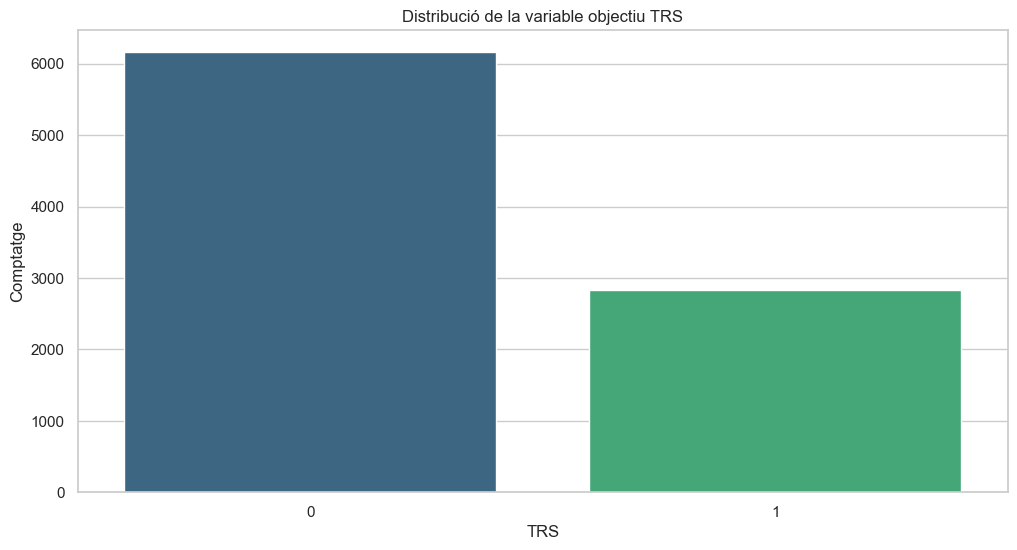

In [5]:
ratio_trs = df['TRS'].value_counts(normalize=True)
print(f"Ratio de classes:\n{ratio_trs}")
plt.figure()
sns.countplot(x='TRS', data=df, palette='viridis')
plt.title('Distribució de la variable objectiu TRS')
plt.xlabel('TRS')
plt.ylabel('Comptatge')
plt.show()

Anàlisi de les variables categòriques en funció de la classe objectiu

Variables categòriques detectades (9):
['Family_history', 'HLA_DRB1_04_02', 'Del_22q11_2_status', 'CYP2D6_metabolic_phenotype', 'Ethnicity', 'HLA_B_15_02', 'Prior_antipsychotics', 'Sex', 'HLA_A_31_01']


VARIABLE                            | P-VALUE    | SIGNIFICATIU?
----------------------------------------------------------------------
Family_history                      | 0.00000    | SÍ !!!


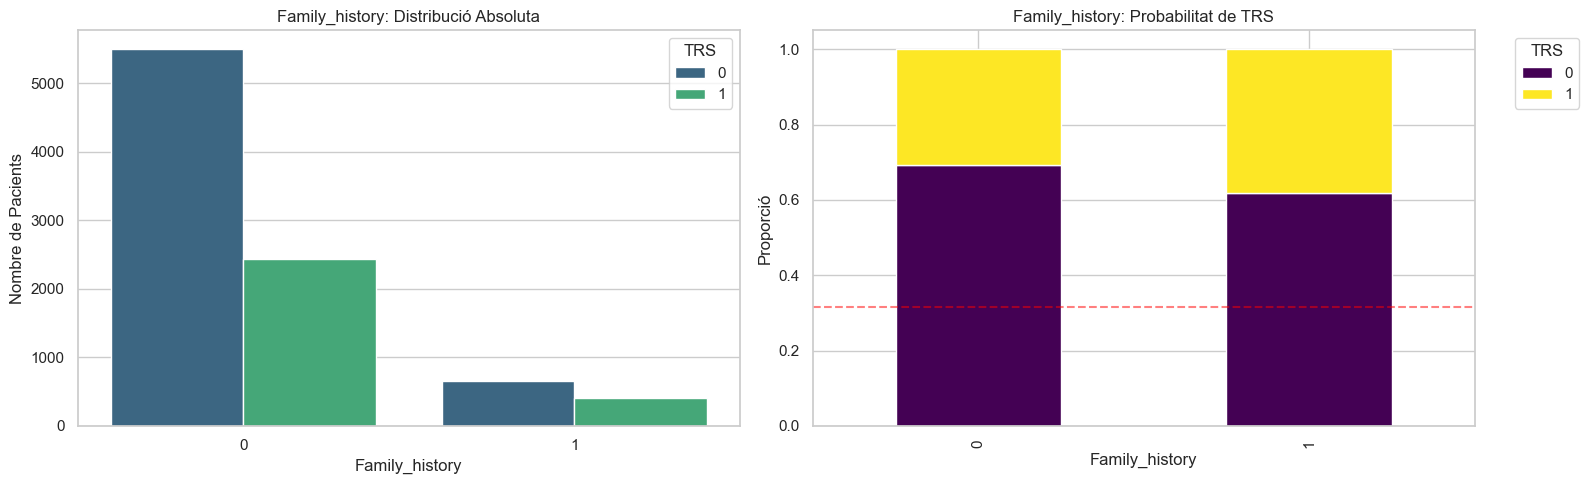

--------------------------------------------------------------------------------
HLA_DRB1_04_02                      | 0.25234    | No


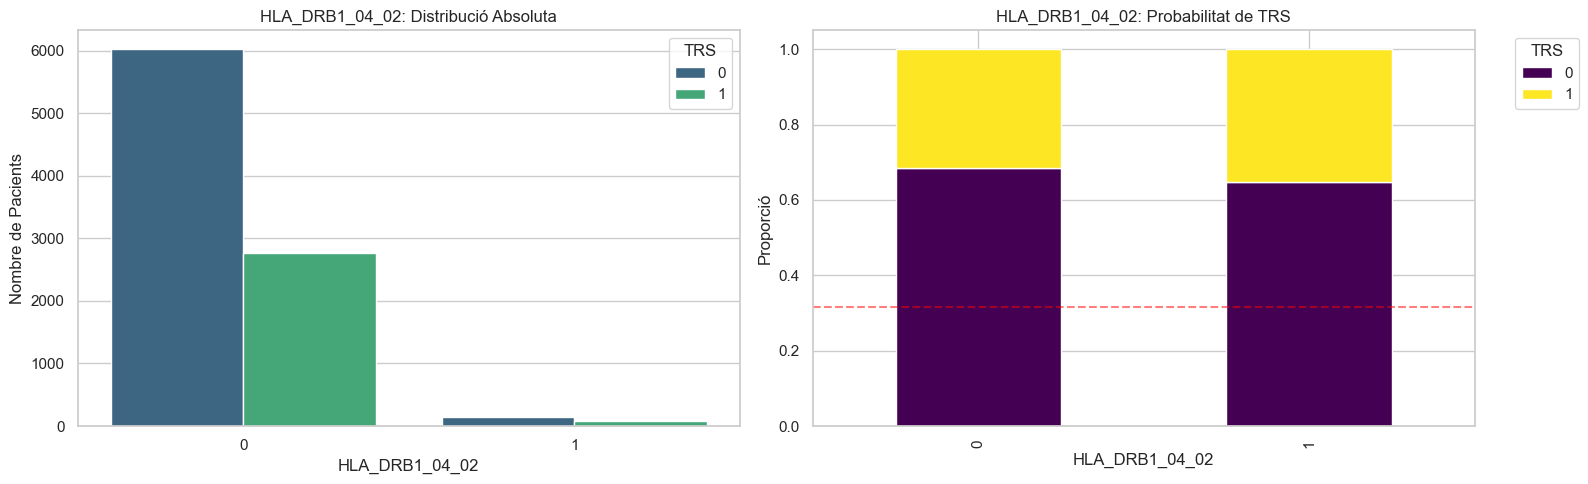

--------------------------------------------------------------------------------
Del_22q11_2_status                  | 0.28333    | No


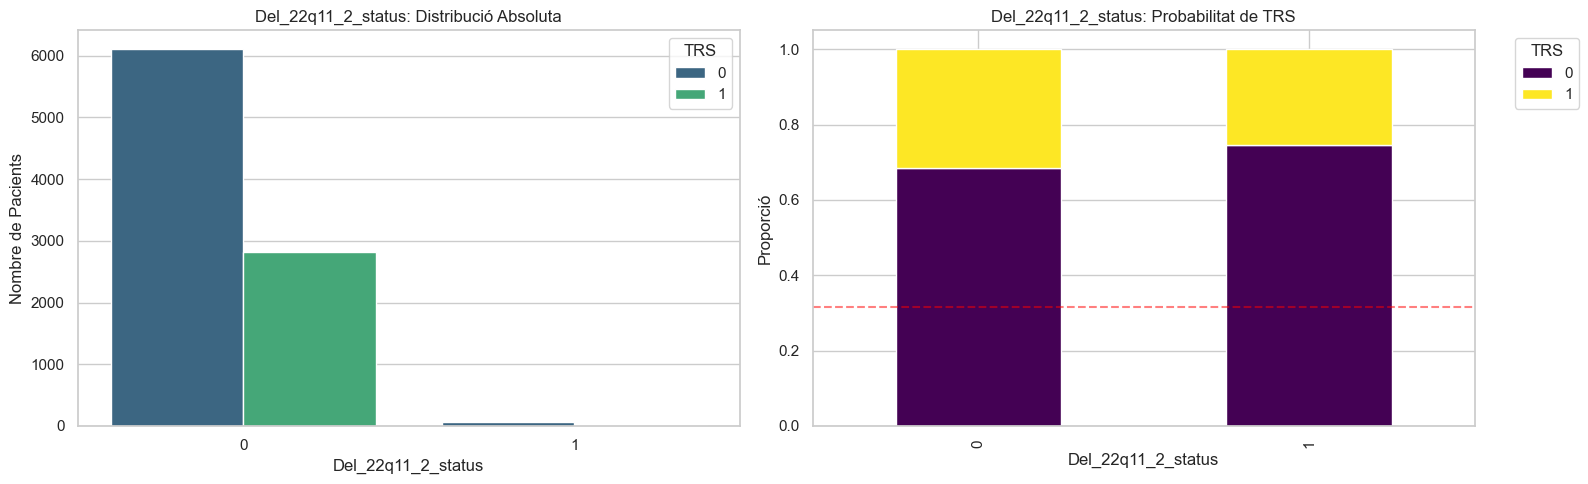

--------------------------------------------------------------------------------
CYP2D6_metabolic_phenotype          | 0.06814    | No


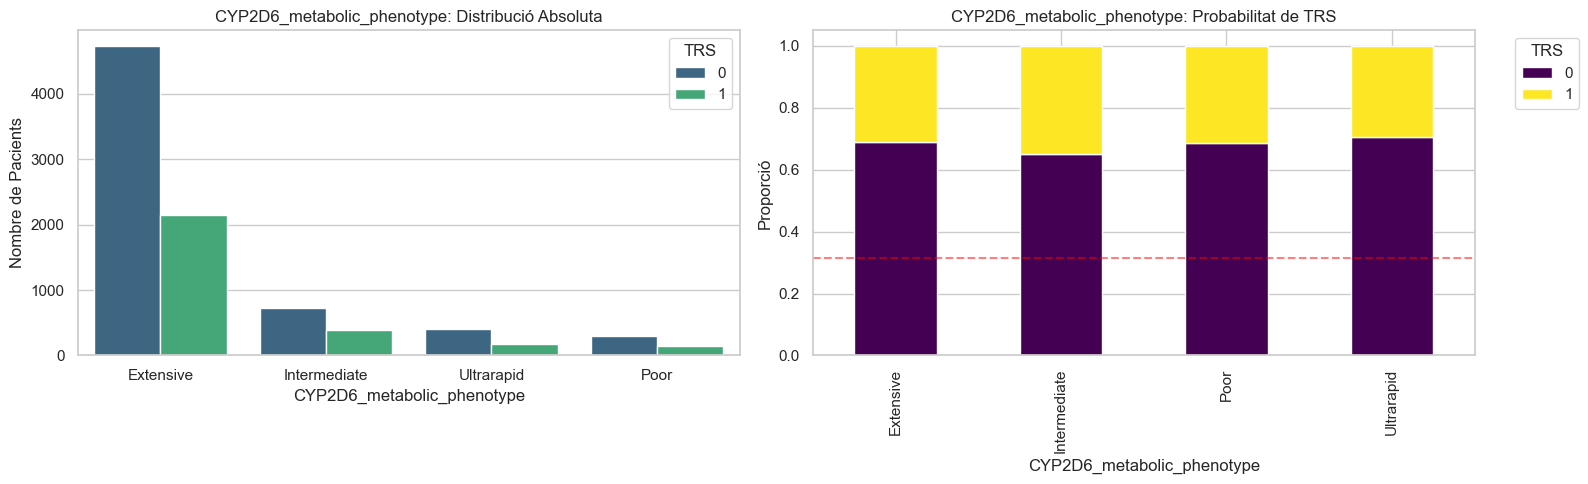

--------------------------------------------------------------------------------
Ethnicity                           | 0.87647    | No


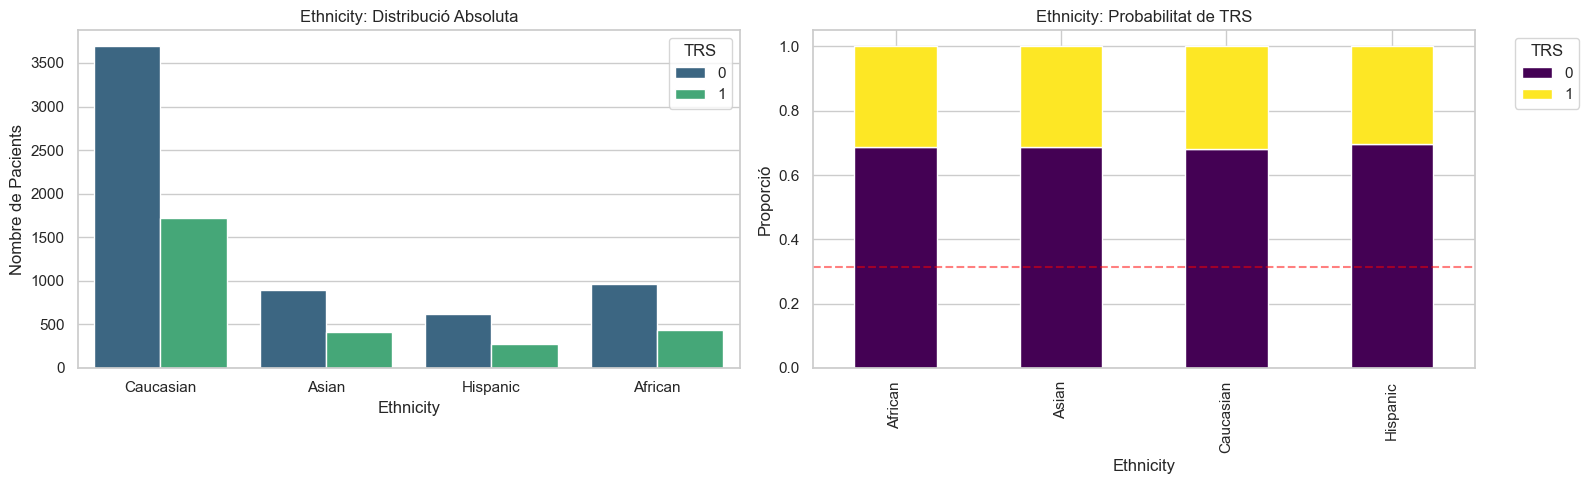

--------------------------------------------------------------------------------
HLA_B_15_02                         | 0.30161    | No


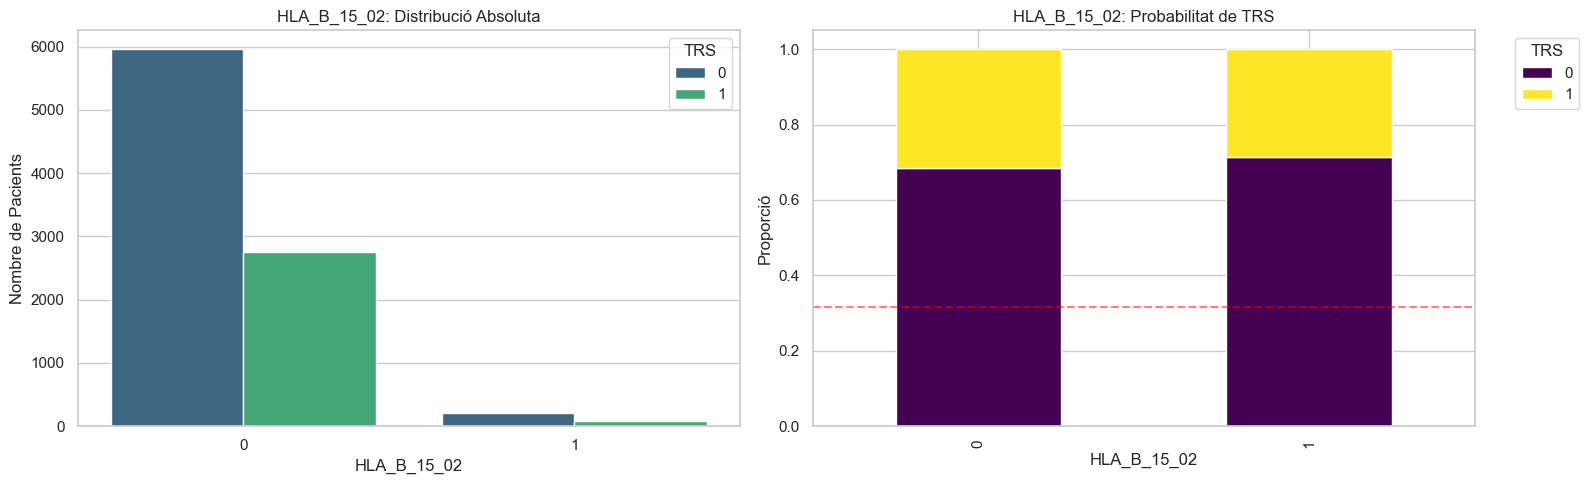

--------------------------------------------------------------------------------
Prior_antipsychotics                | 0.49976    | No


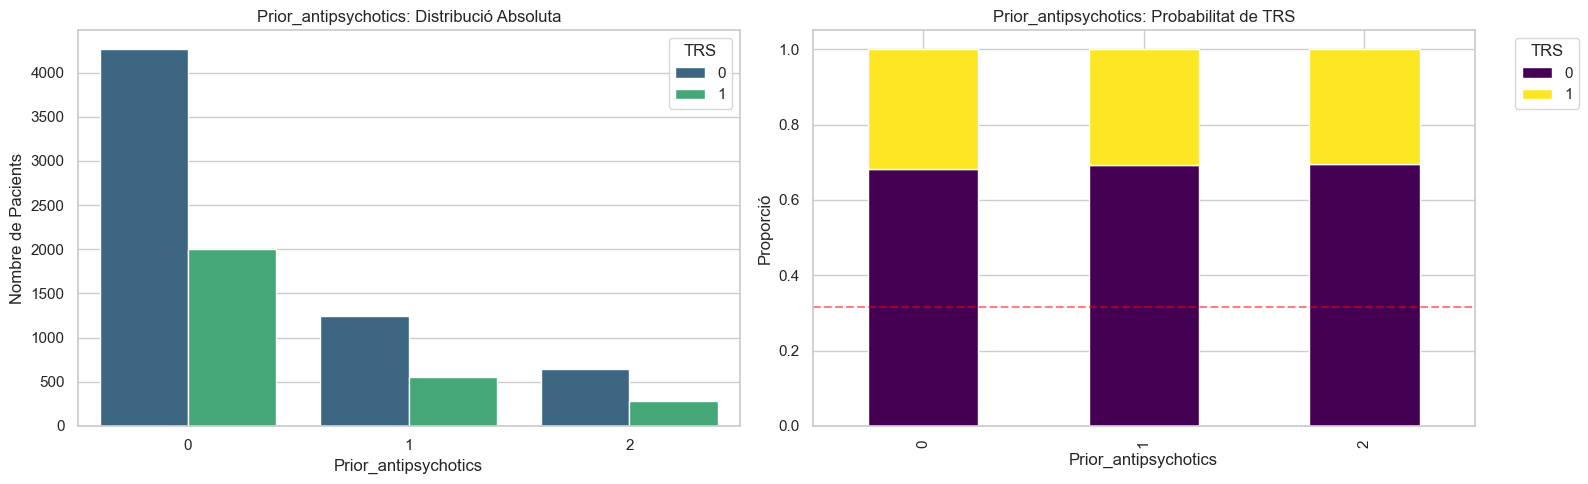

--------------------------------------------------------------------------------
Sex                                 | 0.48567    | No


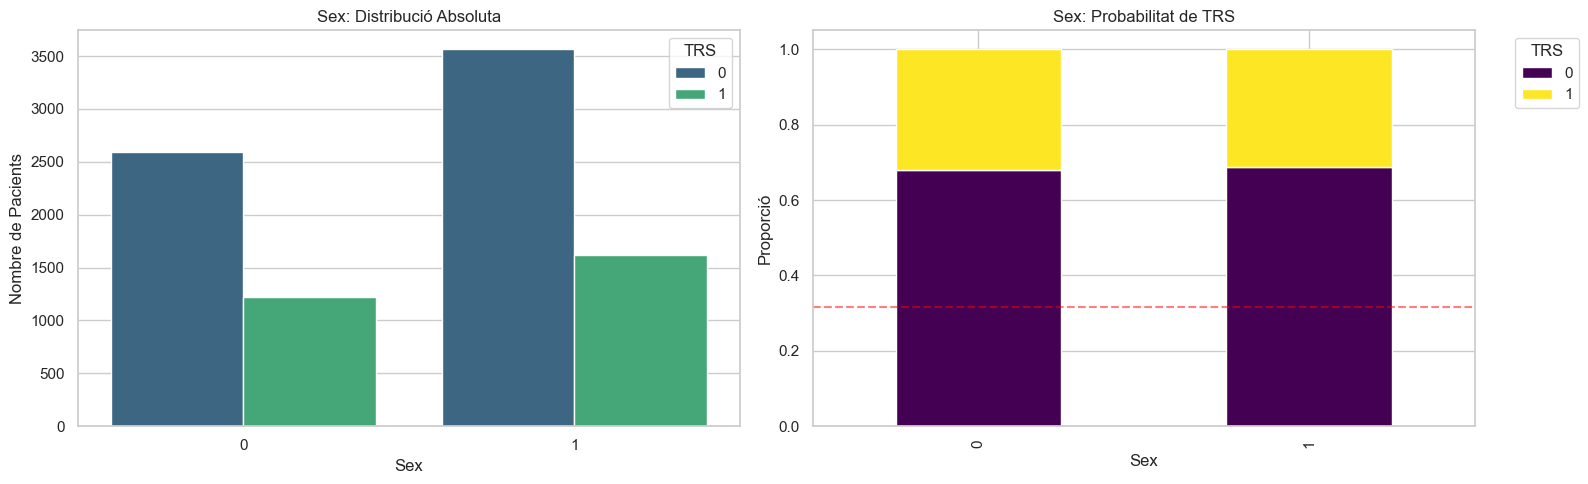

--------------------------------------------------------------------------------
HLA_A_31_01                         | 1.00000    | No


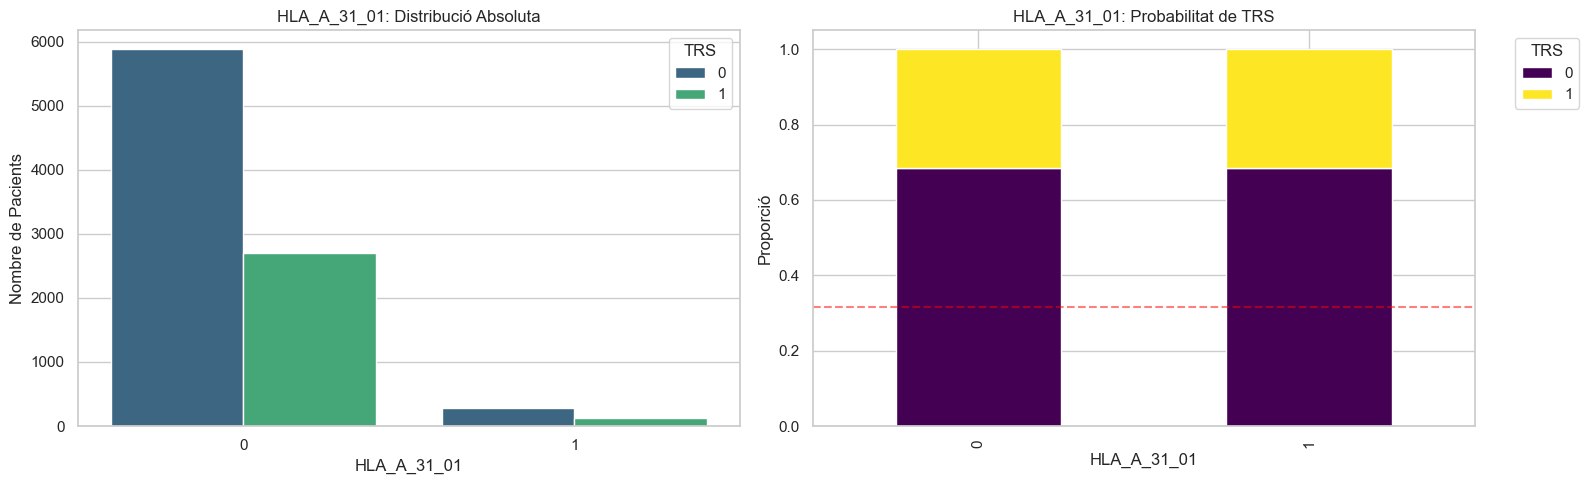

--------------------------------------------------------------------------------


In [6]:

from scipy.stats import chi2_contingency

# 1. Carregar dades
df = pd.read_csv('trs_train.csv')

# 2. DETECCIÓ AUTOMÀTICA DE VARIABLES CATEGÒRIQUES
# ------------------------------------------------
# A. Variables de tipus text (String/Object)
text_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# B. Variables numèriques amb pocs valors únics (ex: Binàries 0/1, o categories numèriques)
# Considerem "categòrica" qualsevol numèrica amb menys de 10 valors únics
num_cols = df.select_dtypes(include=['number']).columns
discrete_num_cols = [col for col in num_cols if df[col].nunique() < 10]

# C. Unim les llistes i netegem
all_categorical_cols = list(set(text_cols + discrete_num_cols))

# D. Eliminem 'TRS' (target) i 'patient_id' (identificador) si hi són
if 'TRS' in all_categorical_cols: all_categorical_cols.remove('TRS')
if 'patient_id' in all_categorical_cols: all_categorical_cols.remove('patient_id')

print(f"Variables categòriques detectades ({len(all_categorical_cols)}):")
print(all_categorical_cols)
print("\n" + "="*80 + "\n")

# 3. ANÀLISI I VISUALITZACIÓ
# -------------------------
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 5)

# Capçalera taula resultats
print(f"{'VARIABLE':<35} | {'P-VALUE':<10} | {'SIGNIFICATIU?'}")
print("-" * 70)

for col in all_categorical_cols:
    # --- A. TEST CHI-QUADRAT ---
    contingency_table = pd.crosstab(df[col], df['TRS'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    is_significant = "SÍ !!!" if p_value < 0.05 else "No"
    print(f"{col:<35} | {p_value:.5f}    | {is_significant}")

    # --- B. GRÀFICS ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Gràfic 1: Absolut (Barres normals)
    sns.countplot(data=df, x=col, hue='TRS', ax=axes[0], palette='viridis')
    axes[0].set_title(f'{col}: Distribució Absoluta')
    axes[0].set_ylabel('Nombre de Pacients')
    
    # Gràfic 2: Relatiu (100% Stacked) - EL MÉS IMPORTANT PER VEURE EL RISC
    props = pd.crosstab(df[col], df['TRS'], normalize='index')
    props.plot(kind='bar', stacked=True, ax=axes[1], colormap='viridis')
    
    axes[1].set_title(f'{col}: Probabilitat de TRS')
    axes[1].set_ylabel('Proporció')
    axes[1].legend(title='TRS', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Línia de la mitjana global
    global_mean = df['TRS'].mean()
    axes[1].axhline(y=global_mean, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    print("-" * 80)


Anàlisi de la distribució de les variables numèriques.
Els models són sensibles a distribucions no normals, per tant, volem una mesura de Skewness també.

In [ ]:
from scipy.stats import skew, kurtosis


num_cols = df.select_dtypes(include=['number']).columns
continuous_cols = [col for col in num_cols if df[col].nunique() > 10 and col != 'patient_id']

print(f"Variables contínues detectades ({len(continuous_cols)}):")
print(continuous_cols)
print("\n" + "="*80 + "\n")

# 3. TAULA RESUM DE SKEWNESS I KURTOSIS
skew_data = []
for col in continuous_cols:
    # Eliminem NaNs per al càlcul estadístic
    clean_series = df[col].dropna()
    col_skew = skew(clean_series)
    col_kurt = kurtosis(clean_series)
    
    # Classifiquem la gravetat de l'asimetria
    if abs(col_skew) > 1:
        status = "🔴 MOLT ASIMÈTRICA (Requereix Log/BoxCox)"
    elif abs(col_skew) > 0.5:
        status = "🟠 MODERADA"
    else:
        status = "🟢 NORMAL (Simètrica)"
        
    skew_data.append({
        'Variable': col,
        'Skewness': col_skew,
        'Kurtosis': col_kurt,
        'Estat': status
    })

skew_df = pd.DataFrame(skew_data).sort_values('Skewness', key=abs, ascending=False)

print("ANÀLISI D'ASIMETRIA (SKEWNESS):")
print("-" * 80)
# Mostrem la taula amb format bonic
print(skew_df.to_string(index=False))
print("-" * 80)
print("Nota: Skewness > 0 significa cua a la dreta. Skewness < 0 significa cua a l'esquerra.")
print("\n" + "="*80 + "\n")

# 4. VISUALITZACIÓ GRÀFICA
sns.set_style("whitegrid")

for col in continuous_cols:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # GRÀFIC 1: Histograma + Densitat (KDE)
    sns.histplot(data=df, x=col, kde=True, ax=axes[0], color='skyblue', bins=30)
    axes[0].set_title(f'Distribució: {col}')
    
    # Afegim línies per Mitjana i Mediana
    axes[0].axvline(df[col].mean(), color='red', linestyle='--', label='Mitjana')
    axes[0].axvline(df[col].median(), color='green', linestyle='-', label='Mediana')
    axes[0].legend()

    # GRÀFIC 2: Boxplot (Per veure Outliers)
    sns.boxplot(x=df[col], ax=axes[1], color='lightgreen')
    axes[1].set_title(f'Boxplot (Outliers): {col}')
    
    plt.tight_layout()
    plt.show()


Anàlisi de les correlacions de les variables numèriques per observar linearitat o colinearitat


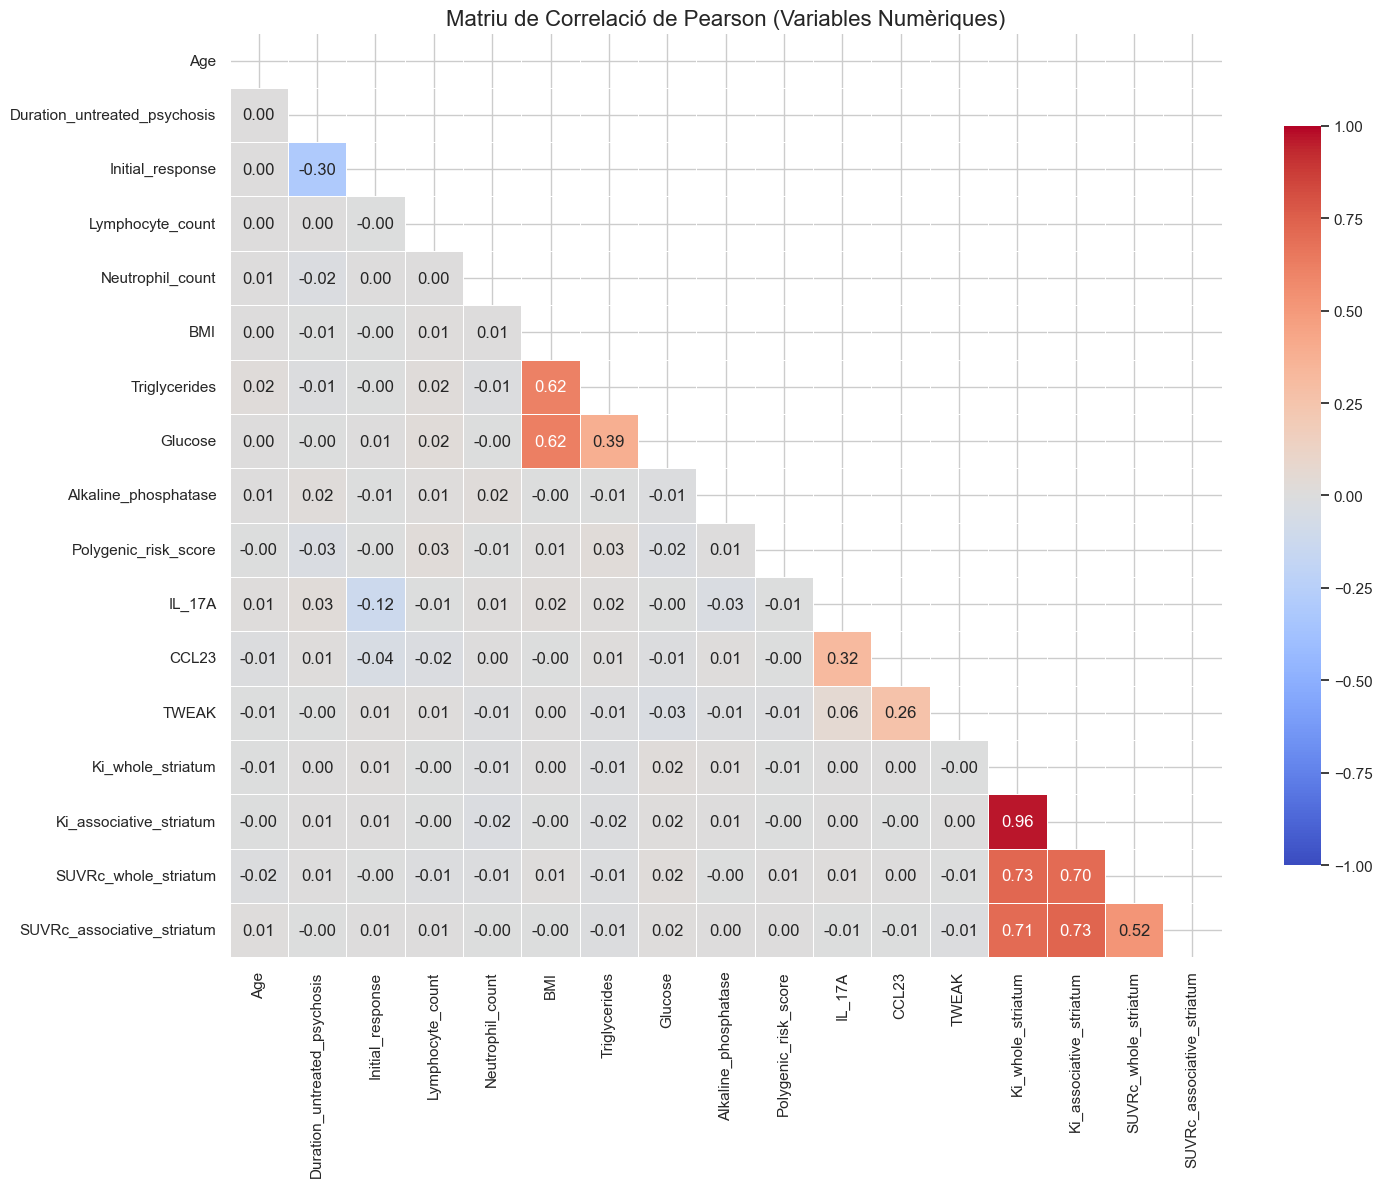


ALERTA DE MULTICOLINEALITAT (Coeficient > 0.7):
------------------------------------------------------------
Ki_associative_striatum        <--> Ki_whole_striatum              : 0.9644
SUVRc_whole_striatum           <--> Ki_whole_striatum              : 0.7265
SUVRc_whole_striatum           <--> Ki_associative_striatum        : 0.7043
SUVRc_associative_striatum     <--> Ki_whole_striatum              : 0.7055
SUVRc_associative_striatum     <--> Ki_associative_striatum        : 0.7336


In [12]:

numerical_cols = df.select_dtypes(include=['number']).columns
# treiem les variables binàries i categòriques codificades numèricament
numerical_cols = [col for col in numerical_cols if df[col].nunique() > 10]
cols_to_analyze = [col for col in numerical_cols if col not in ['patient_id', 'TRS']]

# 3. CALCULAR CORRELACIÓ (Pearson)
corr_matrix = df[cols_to_analyze].corr()

# 4. VISUALITZACIÓ (HEATMAP)
plt.figure(figsize=(16, 12))

# Màscara per amagar la meitat superior (és redundant)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Dibuixar el heatmap
sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True,              # Mostrar números
            fmt=".2f",               # 2 decimals
            cmap='coolwarm',         # Blau-Vermell (Vermell = alta correlació positiva)
            vmax=1, vmin=-1,         # Escala de -1 a 1
            center=0,
            linewidths=.5,
            cbar_kws={"shrink": .8})

plt.title('Matriu de Correlació de Pearson (Variables Numèriques)', fontsize=16)
plt.show()

# 5. LLISTA DE PARELLS AMB ALTA COLINEALITAT (> 0.7 o < -0.7)
print("\nALERTA DE MULTICOLINEALITAT (Coeficient > 0.7):")
print("-" * 60)

# Recorrem la matriu per trobar valors alts
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            var1 = corr_matrix.columns[i]
            var2 = corr_matrix.columns[j]
            coef = corr_matrix.iloc[i, j]
            print(f"{var1:<30} <--> {var2:<30} : {coef:.4f}")
            high_corr_pairs.append((var1, var2, coef))

if not high_corr_pairs:
    print("No s'han detectat problemes greus de multicolinealitat.")


Anàlisi de valors extrems (outliers)

,variable,n_outliers,pct_outliers
1,Duration_untreated_psychosis,651,7.233333
0,Age,360,4.000000
9,Polygenic_risk_score,125,1.388889
14,Ki_associative_striatum,83,0.922222
13,Ki_whole_striatum,71,0.788889
11,CCL23,59,0.655556
12,TWEAK,58,0.644444
10,IL_17A,57,0.633333
5,BMI,39,0.433333
15,SUVRc_whole_striatum,35,0.388889


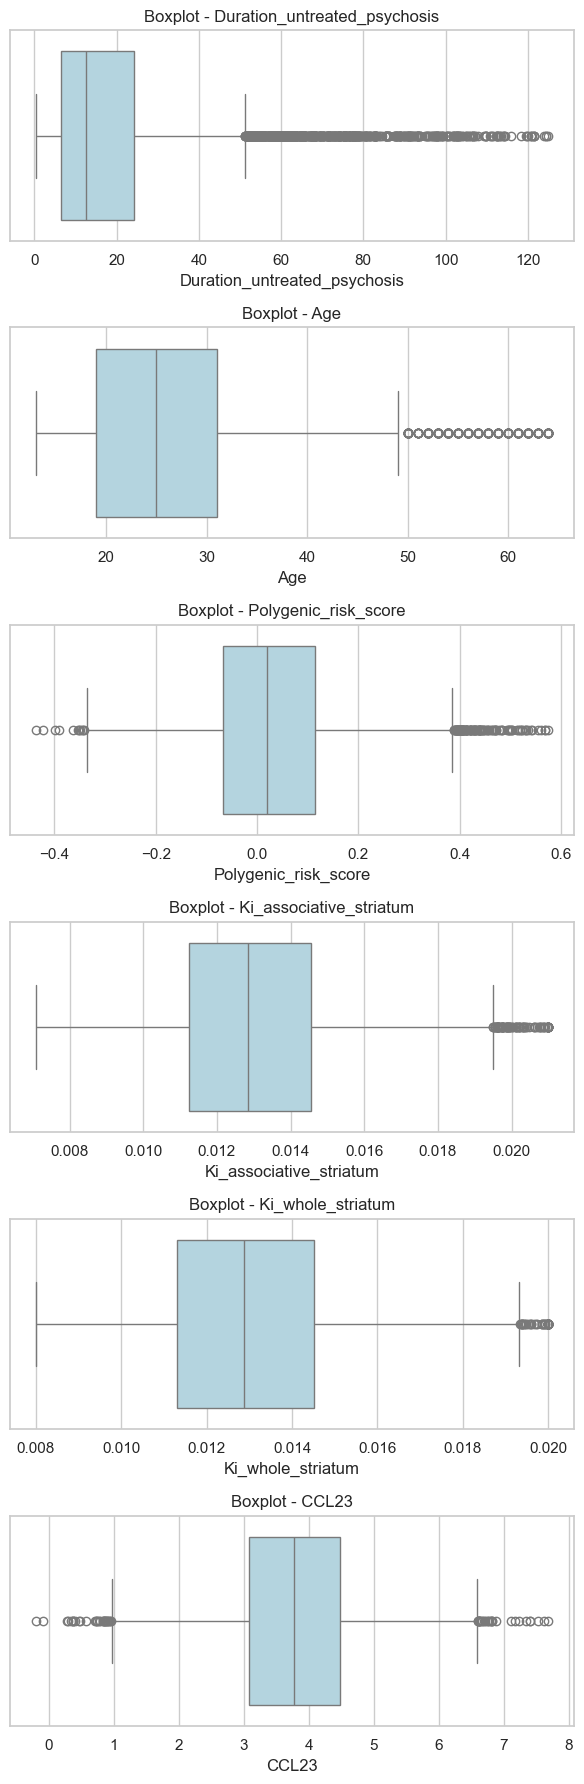

In [9]:
# Detecció d'outliers per a variables numèriques (IQR) i categories rares (<1%) per a categòriques i binàries

# --------------------------
# Numèriques (IQR rule 1.5)
# --------------------------
num_cols = [
    c for c in df.select_dtypes(include='number').columns
    if df[c].nunique() > 10 and c not in ['patient_id']
]

outlier_summary = []
for col in num_cols:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    mask = (df[col] < lower) | (df[col] > upper)
    outlier_summary.append({
        'variable': col,
        'n_outliers': int(mask.sum()),
        'pct_outliers': mask.mean() * 100
    })

outlier_df = pd.DataFrame(outlier_summary).sort_values('pct_outliers', ascending=False)
display(outlier_df)

# Boxplots de les variables amb més outliers (top 6)
top_cols = outlier_df.head(6)['variable']
if len(top_cols) > 0:
    fig, axes = plt.subplots(len(top_cols), 1, figsize=(6, 3 * len(top_cols)))
    if len(top_cols) == 1:
        axes = [axes]
    for ax, col in zip(axes, top_cols):
        sns.boxplot(x=df[col], ax=ax, color='lightblue')
        ax.set_title(f'Boxplot - {col}')
    plt.tight_layout()
    plt.show()

Anàlisi de les components principals. Fem una imputació perquè PCA no tolera NaNs.

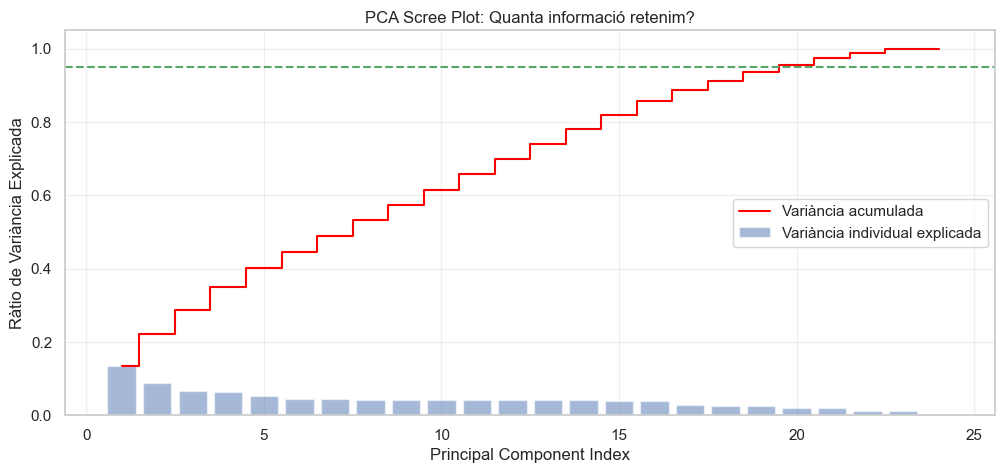

Necessites 20 components per explicar el 95% de la variància.
------------------------------------------------------------


In [ ]:
features = df.select_dtypes(include=['number']).columns.tolist()
if 'patient_id' in features: features.remove('patient_id')
if 'TRS' in features: features.remove('TRS')

X = df[features]


imputer = KNNImputer(n_neighbors=5)
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=features)

# IMPORTANT: PCA requereix dades escalades (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 3. VISUALITZACIÓ (SCREE PLOT)
# -----------------------------
# Variància explicada per cada component
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(12, 5))

# Gràfic de barres (Variància individual)
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center',
        label='Variància individual explicada')

# Gràfic de línia (Variància acumulada)
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid',
         label='Variància acumulada', color='red')

plt.ylabel('Ràtio de Variància Explicada')
plt.xlabel('Principal Component Index')
plt.title('PCA Scree Plot: Quanta informació retenim?')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# Línia de tall al 90% o 95%
plt.axhline(y=0.95, color='g', linestyle='--', label='95% threshold')
plt.show()

# Imprimir quants components calen per arribar al 95%
n_components90 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Necessites {n_components90} components per explicar el 95% de la variància.")
print("-" * 60)


Després d'aquest anàlisi, decidim:

- Per a SVM i Reg. Logística: No eliminem variables, sinó que entrenem amb PCA. També transformatem les variables numèriques per reduir skewness (Box-Cox o Yeo-Johnson segons correspongui).
- Per a XGBoost: No fem PCA, però eliminem variables molt correlacionades (correlació > 0.9) i variables amb skewness > 3 o < -3.


## 2. Preprocessament de dades per model

### 2.1 Per a SVM

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import KNNImputer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Carregar dades
df = pd.read_csv('trs_train.csv')

# Separar X i y
if 'TRS' in df.columns:
    X = df.drop('TRS', axis=1)
    y = df['TRS']
else:
    raise ValueError("No s'ha trobat la columna objectiu 'TRS'")

# Eliminar ID si existeix
if 'patient_id' in X.columns:
    X = X.drop('patient_id', axis=1)

print(f"Dimensions inicials: {X.shape}")


Dimensions inicials: (9000, 26)


1. Particionar

In [44]:
# Dividim 80% Train, 20% Test
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train SVM shape: {X_train_svm.shape}")
print(f"Test SVM shape:  {X_test_svm.shape}")


Train SVM shape: (7200, 26)
Test SVM shape:  (1800, 26)


2. Codificació de variables categòriques amb One-Hot Encoding

In [45]:
# Identifiquem columnes
cat_cols = X_train_svm.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train_svm.select_dtypes(exclude=['object']).columns.tolist()

print(f"Variables categòriques: {cat_cols}")

# Inicialitzem l'encoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')

# Fit només en train
ohe.fit(X_train_svm[cat_cols])

# Transformem
X_train_cat_encoded = ohe.transform(X_train_svm[cat_cols])
X_test_cat_encoded = ohe.transform(X_test_svm[cat_cols])

# Convertim a DataFrame
new_cat_names = ohe.get_feature_names_out(cat_cols)
X_train_cat_df = pd.DataFrame(X_train_cat_encoded, columns=new_cat_names, index=X_train_svm.index)
X_test_cat_df = pd.DataFrame(X_test_cat_encoded, columns=new_cat_names, index=X_test_svm.index)

# Reconstruïm els DataFrames (Numèriques + Categòriques codificades)
X_train_svm = pd.concat([X_train_svm[num_cols], X_train_cat_df], axis=1)
X_test_svm = pd.concat([X_test_svm[num_cols], X_test_cat_df], axis=1)

print(f"Dimensions després One-Hot: {X_train_svm.shape}")


Variables categòriques: ['Ethnicity', 'CYP2D6_metabolic_phenotype']
Dimensions després One-Hot: (7200, 30)


3. Imputació de valors faltants amb KNNImputer amb ``k=5``

In [46]:
# 1. Escalat Temporal per al KNN (imprescindible per distàncies)
scaler_temp = StandardScaler()
# Ajustem l'escalador temporal sobre les dades actuals
X_train_scaled_temp = scaler_temp.fit_transform(X_train_svm)
X_test_scaled_temp = scaler_temp.transform(X_test_svm)

# 2. Aplicar KNN Imputer
knn = KNNImputer(n_neighbors=5)
X_train_imputed_vals = knn.fit_transform(X_train_scaled_temp)
X_test_imputed_vals = knn.transform(X_test_scaled_temp)

# 3. Tornar a l'escala original (Inverse Transform) per poder aplicar Box-Cox després
X_train_svm = pd.DataFrame(scaler_temp.inverse_transform(X_train_imputed_vals), 
                           columns=X_train_svm.columns, index=X_train_svm.index)
X_test_svm = pd.DataFrame(scaler_temp.inverse_transform(X_test_imputed_vals), 
                          columns=X_test_svm.columns, index=X_test_svm.index)

print(f"Valors perduts restants: {X_train_svm.isnull().sum().sum()}")


Valors perduts restants: 0


4. Transformació de variables numèriques per reduir skewness amb PowerTransformer (Box-Cox o Yeo-Johnson segons correspongui)

In [47]:
pt = PowerTransformer(method='yeo-johnson', standardize=False)

cols_skewed = ['Duration_untreated_psychosis', 'Age']

# Fit només en train
pt.fit(X_train_svm[cols_skewed])

# Transformem les columnes específiques
X_train_svm[cols_skewed] = pt.transform(X_train_svm[cols_skewed])
X_test_svm[cols_skewed] = pt.transform(X_test_svm[cols_skewed])

print("Transformació d'asimetria completada.")


Transformació d'asimetria completada.


5. Escalat de les variables numèriques amb StandardScaler

In [48]:
scaler_final = StandardScaler()

X_train_svm_final = scaler_final.fit_transform(X_train_svm)
X_test_svm_final = scaler_final.transform(X_test_svm)

print("Escalat final completat. Dades llestes per al model.")


Escalat final completat. Dades llestes per al model.


6. Entrenament del model SVM

In [34]:


#calculem proporció de la classe objectiu per definir pesos
class_counts = y_train_svm.value_counts()
print("Comptatge de classes en el conjunt d'entrenament:") 
print(class_counts)
print("\n" + "="*50 + "\n")

class_weights = {
    0: 1,
    1: class_counts[0] / class_counts[1]  # Pes inversament proporcional a la freqüència
}

param_grid = {
    'C': [0.001, 0.01, 0.1, 1], 
    'gamma': ['scale', 'auto', 0.01],
    'kernel': ['rbf', 'linear', 'poly'],
    'class_weight': ['balanced', {0: 1, 1: 2}, class_weights],
    'degree': [2, 3, 4]  
}
svm_base = SVC(class_weight='balanced', random_state=42)


grid_search = GridSearchCV(
    estimator=svm_base,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    verbose=2,
    n_jobs=-1
)

# 4. Executar el Grid Search (Fit sobre les dades entrenament processades)
print("Iniciant Grid Search per SVM...")
grid_search.fit(X_train_svm_final, y_train_svm)

# 5. Mostrar els millors resultats
print("\n" + "="*50)
print(f"MILLORS PARÀMETRES: {grid_search.best_params_}")
print(f"MILLOR F1-SCORE (CV): {grid_search.best_score_:.4f}")
print("="*50 + "\n")

# 6. Avaluar el millor model sobre el Test Set
best_svm = grid_search.best_estimator_
y_pred_best = best_svm.predict(X_test_svm_final)

print("--- RESULTATS DEL MILLOR MODEL (TEST SET) ---")
print(classification_report(y_test_svm, y_pred_best))

# retornem el valor f1-score del millor model en el test set
f1 = f1_score(y_test_svm, y_pred_best, average='macro')
print(f"F1-Score del millor model en Test Set: {f1:.4f}")



Comptatge de classes en el conjunt d'entrenament:
TRS
0    4930
1    2270
Name: count, dtype: int64


Iniciant Grid Search per SVM...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

MILLORS PARÀMETRES: {'C': 0.1, 'class_weight': 'balanced', 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}
MILLOR F1-SCORE (CV): 0.5895

--- RESULTATS DEL MILLOR MODEL (TEST SET) ---
              precision    recall  f1-score   support

           0       0.75      0.64      0.69      1232
           1       0.40      0.53      0.46       568

    accuracy                           0.60      1800
   macro avg       0.57      0.58      0.57      1800
weighted avg       0.64      0.60      0.62      1800

F1-Score del millor model en Test Set: 0.5729


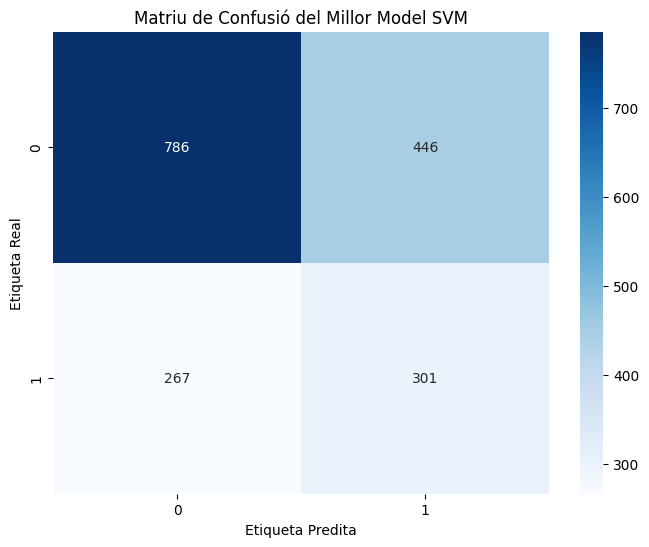

In [49]:
best_svm = SVC(C=0.1, gamma='auto', kernel='poly', degree=3, class_weight='balanced', random_state=42)
best_svm.fit(X_train_svm_final, y_train_svm)
y_pred_best = best_svm.predict(X_test_svm_final)

cm = confusion_matrix(y_test_svm, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=best_svm.classes_, 
            yticklabels=best_svm.classes_)
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predita')
plt.title('Matriu de Confusió del Millor Model SVM')
plt.show()

Generem corba ROC i AUC per avaluar el model.

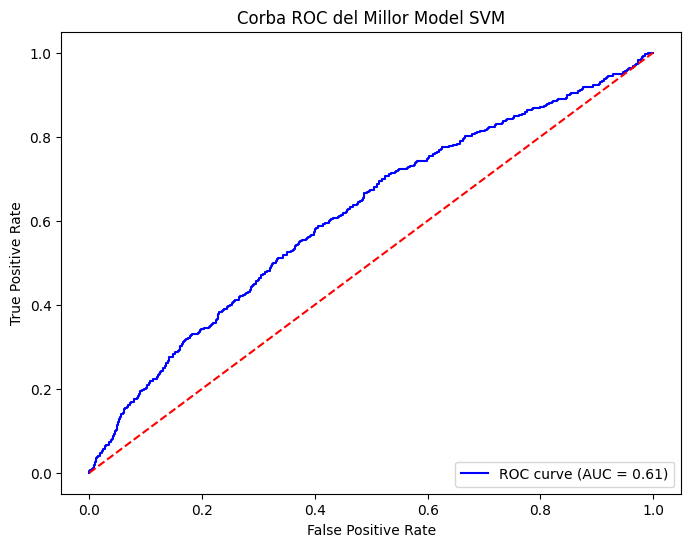

In [50]:
# Corba ROC i AUC
from sklearn.metrics import roc_curve, auc
y_prob_best = best_svm.decision_function(X_test_svm_final)
fpr, tpr, thresholds = roc_curve(y_test_svm, y_prob_best)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Corba ROC del Millor Model SVM')
plt.legend(loc='lower right')
plt.show()

Mirem les puntacions d'entrenament i validació creuada per detectar overfitting o underfitting.

In [51]:
train_acc = best_svm.score(X_train_svm_final, y_train_svm)
test_acc = best_svm.score(X_test_svm_final, y_test_svm)

print(f"Accuracy d'entrenament: {train_acc:.4f}")
print(f"Accuracy de test: {test_acc:.4f}")

Accuracy d'entrenament: 0.6786
Accuracy de test: 0.6039


Veiem lleuger sobreajustament en el model SVM, amb una diferència notable entre l'accuracy al conjunt d'entrenament i al conjunt de prova. Proposem provar valors més alts de regularització `C`:

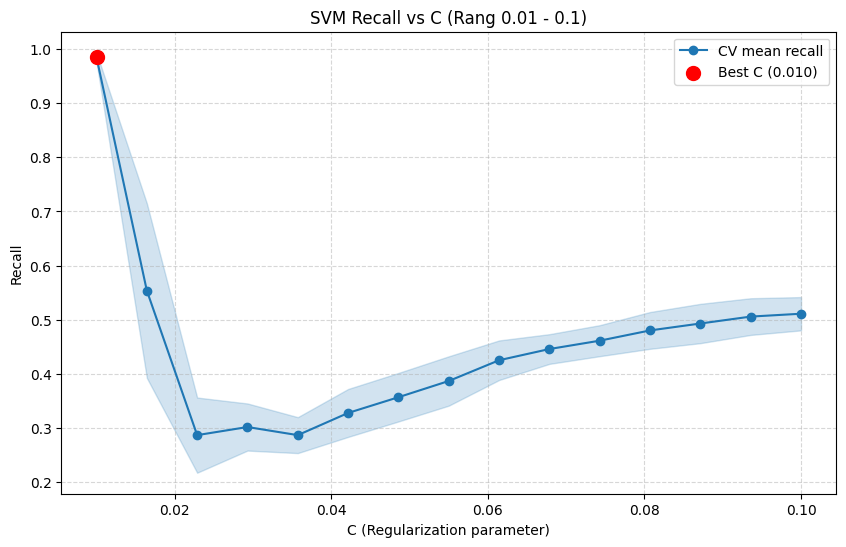

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

c_values = np.linspace(0.01, 0.1, 15)  
cv_means = []
cv_stds = []

for c in c_values:
    svm = SVC(kernel='poly', degree=3, C=c, gamma='auto', class_weight='balanced')
    
    scores = cross_val_score(svm, X_train_svm_final, y_train_svm, cv=5, scoring='recall')
    
    cv_means.append(np.mean(scores))
    cv_stds.append(np.std(scores))

cv_means = np.array(cv_means)
cv_stds = np.array(cv_stds)

plt.figure(figsize=(10, 6))

plt.plot(c_values, cv_means, '-o', label='CV mean recall', color='tab:blue')
plt.fill_between(c_values, cv_means - cv_stds, cv_means + cv_stds, 
                 alpha=0.2, color='tab:blue')

best_idx = np.argmax(cv_means)
plt.scatter(c_values[best_idx], cv_means[best_idx], color='red', 
            s=100, label=f'Best C ({c_values[best_idx]:.3f})', zorder=5)

# Configuració d'eixos (ara en escala lineal ja que el rang és petit)
plt.xlabel('C (Regularization parameter)')
plt.ylabel('Recall')
plt.title('SVM Recall vs C (Rang 0.01 - 0.1)')
plt.grid(True, ls="--", alpha=0.5)
plt.legend()
plt.show()


Generem el model final amb el millor valor de `C` i obtenim les següents mètriques al test set:

              precision    recall  f1-score   support

           0       0.74      0.69      0.71      1232
           1       0.42      0.49      0.45       568

    accuracy                           0.62      1800
   macro avg       0.58      0.59      0.58      1800
weighted avg       0.64      0.62      0.63      1800



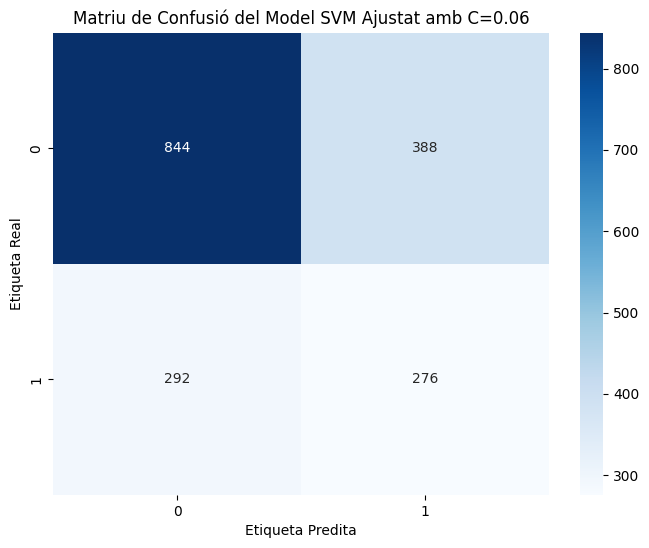

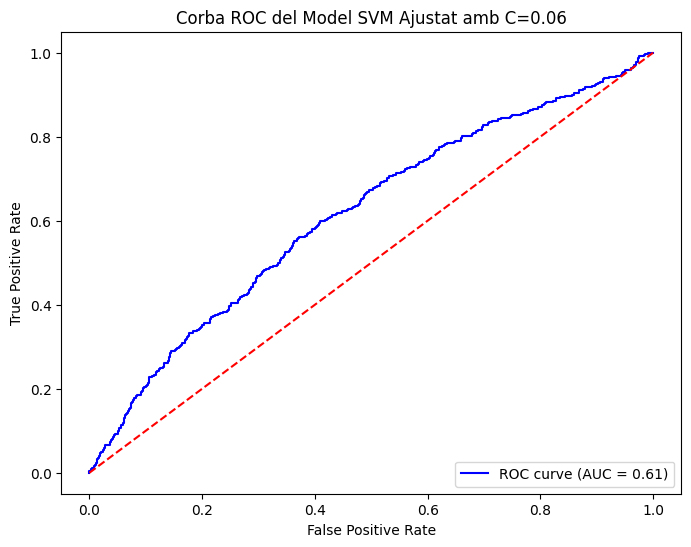

Accuracy d'entrenament: 0.6804
Accuracy de test: 0.6222


In [67]:
best_svm = SVC(C=0.06, gamma='auto', kernel='poly', degree=3, class_weight='balanced', random_state=42)
best_svm.fit(X_train_svm_final, y_train_svm)
y_pred_best = best_svm.predict(X_test_svm_final)

print(classification_report(y_test_svm, y_pred_best))

cm = confusion_matrix(y_test_svm, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_svm.classes_, 
            yticklabels=best_svm.classes_)
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predita')
plt.title('Matriu de Confusió del Model SVM Ajustat amb C=0.06')
plt.show()

# Corba ROC i AUC
from sklearn.metrics import roc_curve, auc
y_prob_best = best_svm.decision_function(X_test_svm_final)
fpr, tpr, thresholds = roc_curve(y_test_svm, y_prob_best)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Corba ROC del Model SVM Ajustat amb C=0.06')
plt.legend(loc='lower right')
plt.show()

train_acc = best_svm.score(X_train_svm_final, y_train_svm)
test_acc = best_svm.score(X_test_svm_final, y_test_svm)
print(f"Accuracy d'entrenament: {train_acc:.4f}")
print(f"Accuracy de test: {test_acc:.4f}")

Per tal de generar una submission, haurem de preprocessar de la mateixa manera el dataset trs_eval.csv abans de fer les prediccions.

In [68]:
# 1. Carregar dades d'avaluació
df_eval = pd.read_csv('trs_eval.csv')

eval_ids = df_eval['patient_id']
X_eval = df_eval.drop('patient_id', axis=1) if 'patient_id' in df_eval.columns else df_eval.copy()

print(f"Dimensions inicials eval: {X_eval.shape}")

# one-hot encoding
cat_cols_eval = X_eval.select_dtypes(include=['object']).columns.tolist()
num_cols_eval = X_eval.select_dtypes(exclude=['object']).columns.tolist()

X_eval_cat_encoded = ohe.transform(X_eval[cat_cols_eval])
X_eval_cat_df = pd.DataFrame(X_eval_cat_encoded, columns=new_cat_names, index=X_eval.index)
X_eval_step2 = pd.concat([X_eval[num_cols_eval], X_eval_cat_df], axis=1)
print(f"Dimensions després One-Hot: {X_eval_step2.shape}")

#imputació KNN amb escalat temporal
X_eval_scaled_temp = scaler_temp.transform(X_eval_step2)
X_eval_imputed_vals = knn.transform(X_eval_scaled_temp)
X_eval_step3 = pd.DataFrame(scaler_temp.inverse_transform(X_eval_imputed_vals), 
                            columns=X_eval_step2.columns, index=X_eval.index)

print(f"NaNs restants: {X_eval_step3.isnull().sum().sum()}")

# Transformació 
cols_skewed = ['Duration_untreated_psychosis', 'Age']
X_eval_step3[cols_skewed] = pt.transform(X_eval_step3[cols_skewed])
print("Transformació Box-Cox aplicada.")

# Escalat final
X_eval_final = scaler_final.transform(X_eval_step3)
print("Escalat final aplicat.")


# Prediccions finals
final_predictions = best_svm.predict(X_eval_final) # o svm_model.predict()

submission = pd.DataFrame({
    'patient_id': eval_ids,
    'TRS': final_predictions
})

submission.to_csv('submission.csv', index=False)


Dimensions inicials eval: (1000, 26)
Dimensions després One-Hot: (1000, 30)
NaNs restants: 0
Transformació Box-Cox aplicada.
Escalat final aplicat.


## 2.2 Per a XGBoost

1. Particionar

In [69]:
df = pd.read_csv('trs_train.csv')

if 'TRS' in df.columns:
    X = df.drop('TRS', axis=1)
    y = df['TRS']
else:
    raise ValueError("No s'ha trobat la columna TRS")

if 'patient_id' in X.columns:
    X = X.drop('patient_id', axis=1)

print(f"Dimensions inicials: {X.shape}")

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train XGB shape: {X_train_xgb.shape}")

Dimensions inicials: (9000, 26)
Train XGB shape: (7200, 26)


2. Codificació de variables categòriques amb One-Hot Encoding

In [70]:
cat_cols = X_train_xgb.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train_xgb.select_dtypes(exclude=['object']).columns.tolist()

ohe_xgb = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')

ohe_xgb.fit(X_train_xgb[cat_cols])

X_train_cat = ohe_xgb.transform(X_train_xgb[cat_cols])
X_test_cat = ohe_xgb.transform(X_test_xgb[cat_cols])

new_names = ohe_xgb.get_feature_names_out(cat_cols)
X_train_cat_df = pd.DataFrame(X_train_cat, columns=new_names, index=X_train_xgb.index)
X_test_cat_df = pd.DataFrame(X_test_cat, columns=new_names, index=X_test_xgb.index)

X_train_xgb = pd.concat([X_train_xgb[num_cols], X_train_cat_df], axis=1)
X_test_xgb = pd.concat([X_test_xgb[num_cols], X_test_cat_df], axis=1)

print(f"Dimensions després encoding: {X_train_xgb.shape}")


Dimensions després encoding: (7200, 30)


3. Imputació de valors faltants amb KNNImputer amb ``k=5``

In [4]:
from sklearn.preprocessing import StandardScaler
scaler_temp_xgb = StandardScaler()

X_train_scaled_temp = scaler_temp_xgb.fit_transform(X_train_xgb)
X_test_scaled_temp = scaler_temp_xgb.transform(X_test_xgb)

knn_xgb = KNNImputer(n_neighbors=5)

X_train_imputed = knn_xgb.fit_transform(X_train_scaled_temp)
X_test_imputed = knn_xgb.transform(X_test_scaled_temp)


X_train_xgb = pd.DataFrame(scaler_temp_xgb.inverse_transform(X_train_imputed), 
                           columns=X_train_xgb.columns, index=X_train_xgb.index)
X_test_xgb = pd.DataFrame(scaler_temp_xgb.inverse_transform(X_test_imputed), 
                          columns=X_test_xgb.columns, index=X_test_xgb.index)

print(f"Valors perduts restants: {X_train_xgb.isnull().sum().sum()}")

Valors perduts restants: 0


4. Entrenament del model XGBoost

In [95]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

ratio_xgb = float(np.sum(y_train_xgb == 0)) / np.sum(y_train_xgb == 1)

# Definir el model base
xgb_base = xgb.XGBClassifier(
    objective='binary:logistic', #objectiu binari
    random_state=42,
    n_jobs=-1,
)

param_grid_xgb = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9],
    'scale_pos_weight': [ratio_xgb],
    'colsample_bytree': [0.8, 0.9],
    'min_child_weight': [3, 5, 7],
    'reg_alpha': [0.1, 0.5, 1],
    'reg_lambda': [0.1, 0.5, 1],
    'gamma': [0.1, 0.2]
}

# 4. Configurar el Grid Search
grid_xgb = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid_xgb,
    cv=5,                 # 5-Fold Cross Validation
    scoring='f1_macro',   # O 'roc_auc' si prefereixes
    verbose=1,
    n_jobs=-1             # Paral·lelització total
)

# 5. Entrenar
print("Iniciant Grid Search per XGBoost...")
grid_xgb.fit(X_train_xgb, y_train_xgb)

# 6. Resultats
print("\n" + "="*50)
print(f"MILLORS PARÀMETRES: {grid_xgb.best_params_}")
print(f"MILLOR SCORE (CV): {grid_xgb.best_score_:.4f}")
print("="*50)

# 7. Avaluar al Test Set
best_xgb = grid_xgb.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test_xgb)

print("\n--- RESULTATS MILLOR XGBOOST (TEST SET) ---")
print(classification_report(y_test_xgb, y_pred_best_xgb))


Iniciant Grid Search per XGBoost...
Fitting 5 folds for each of 5832 candidates, totalling 29160 fits

MILLORS PARÀMETRES: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 300, 'reg_alpha': 1, 'reg_lambda': 1, 'scale_pos_weight': np.float64(2.171806167400881), 'subsample': 0.8}
MILLOR SCORE (CV): 0.5791

--- RESULTATS MILLOR XGBOOST (TEST SET) ---
              precision    recall  f1-score   support

           0       0.75      0.58      0.65      1232
           1       0.39      0.59      0.47       568

    accuracy                           0.58      1800
   macro avg       0.57      0.58      0.56      1800
weighted avg       0.64      0.58      0.60      1800



Visualitzem la matriu de confusió:

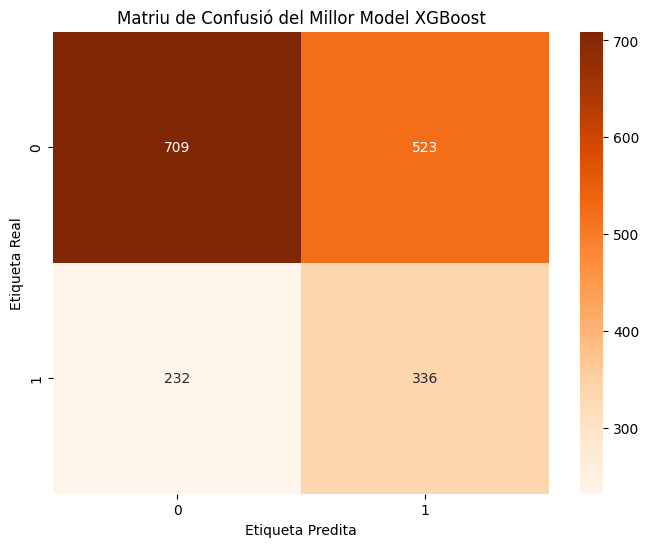

In [96]:
# veiem la matriu de confusió
cm_xgb = confusion_matrix(y_test_xgb, y_pred_best_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=best_xgb.classes_, 
            yticklabels=best_xgb.classes_)  
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predita')
plt.title('Matriu de Confusió del Millor Model XGBoost')
plt.show()

Visualitzem la corba ROC i l'AUC per avaluar el model.

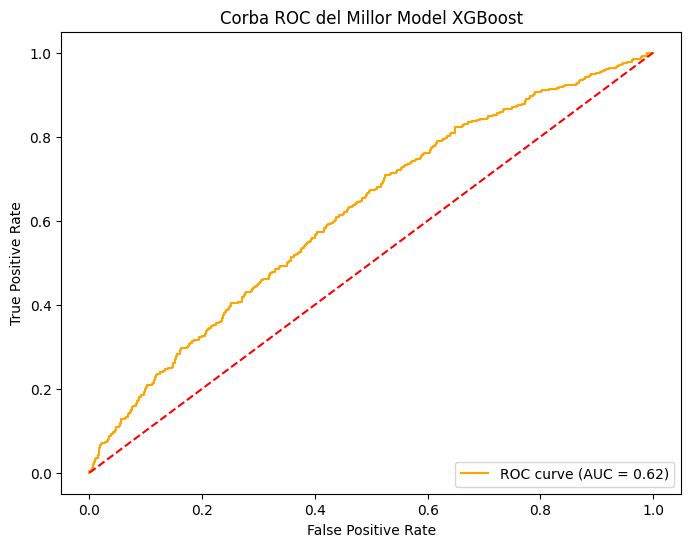

In [97]:
y_prob_best_xgb = best_xgb.predict_proba(X_test_xgb)[:, 1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test_xgb, y_prob_best_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='orange', label=f'ROC curve (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Corba ROC del Millor Model XGBoost')
plt.legend(loc='lower right')
plt.show()

Mirem les corbes d'aprenentatge per detectar overfitting o underfitting.

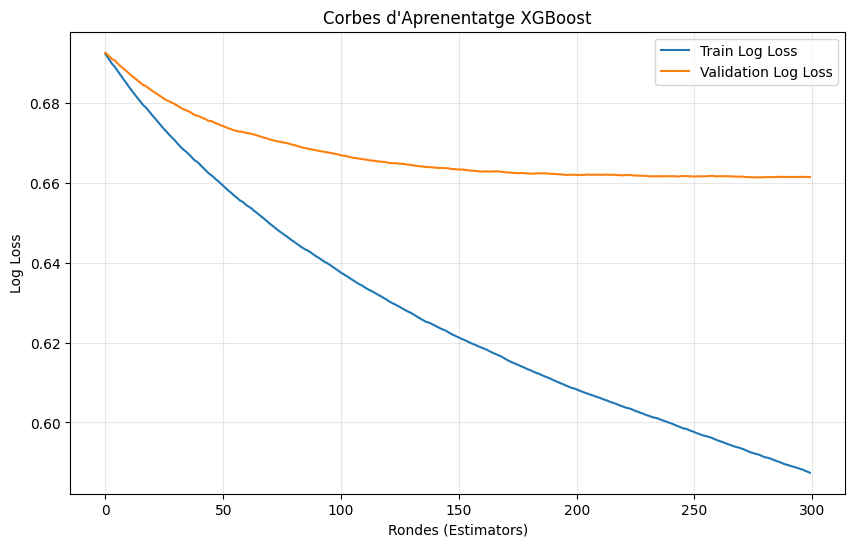

In [105]:
import xgboost as xgb
import matplotlib.pyplot as plt


model_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    n_jobs=-1,
    **grid_xgb.best_params_  # Utilitzem els millors paràmetres trobats   

)

eval_set = [
    (X_train_xgb, y_train_xgb),  # Corba d'entrenament (Train)
    (X_test_xgb, y_test_xgb)     # Corba de validació (Test)
]

model_xgb.fit(
    X_train_xgb, y_train_xgb,
    eval_set=eval_set, 
    verbose=False,           
)

results = model_xgb.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train Log Loss', color='#1f77b4') # Blau
plt.plot(x_axis, results['validation_1']['logloss'], label='Validation Log Loss', color='#ff7f0e') # Taronja

plt.legend()
plt.xlabel('Rondes (Estimators)')
plt.ylabel('Log Loss')
plt.title("Corbes d'Aprenentatge XGBoost")
plt.grid(True, alpha=0.3)
plt.show()


In [104]:
df_eval_xgb = pd.read_csv('trs_eval.csv')

eval_ids_xgb = df_eval_xgb['patient_id']
X_eval_xgb = df_eval_xgb.drop('patient_id', axis=1) if 'patient_id' in df_eval_xgb.columns else df_eval_xgb.copy()
print(f"Dimensions inicials eval XGB: {X_eval_xgb.shape}")
# One-Hot Encoding
cat_cols_eval_xgb = X_eval_xgb.select_dtypes(include=['object']).columns.tolist()
num_cols_eval_xgb = X_eval_xgb.select_dtypes(exclude=['object']).columns.tolist()
X_eval_cat_xgb = ohe_xgb.transform(X_eval_xgb[cat_cols_eval_xgb])
X_eval_cat_df_xgb = pd.DataFrame(X_eval_cat_xgb, columns=new_names, index=X_eval_xgb.index)
X_eval_step2_xgb = pd.concat([X_eval_xgb[num_cols_eval_xgb], X_eval_cat_df_xgb], axis=1)
print(f"Dimensions després One-Hot XGB: {X_eval_step2_xgb.shape}")
# Imputació KNN
X_eval_scaled_temp_xgb = scaler_temp_xgb.transform(X_eval_step2_xgb)
X_eval_imputed_xgb = knn_xgb.transform(X_eval_scaled_temp_xgb)
X_eval_step3_xgb = pd.DataFrame(scaler_temp_xgb.inverse_transform(X_eval_imputed_xgb), 
                            columns=X_eval_step2_xgb.columns, index=X_eval_step2_xgb.index)
print(f"NaNs restants XGB: {X_eval_step3_xgb.isnull().sum().sum()}")
# Prediccions
final_predictions_xgb = best_xgb.predict(X_eval_step3_xgb)
submission_xgb = pd.DataFrame({
    'patient_id': eval_ids_xgb,
    'TRS': final_predictions_xgb
})
submission_xgb.to_csv('submission_xgb.csv', index=False)



Dimensions inicials eval XGB: (1000, 26)
Dimensions després One-Hot XGB: (1000, 30)
NaNs restants XGB: 0


## 2.3 Per a Regressió Logística personalitzada

1. Particionar


In [4]:
df = pd.read_csv('trs_train.csv')

if 'TRS' in df.columns:
    X = df.drop('TRS', axis=1)
    y = df['TRS']
else:
    raise ValueError("No s'ha trobat la columna TRS")

if 'patient_id' in X.columns:
    X = X.drop('patient_id', axis=1)

print(f"Dimensions inicials: {X.shape}")

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train LogReg shape: {X_train_lr.shape}")

Dimensions inicials: (9000, 26)
Train LogReg shape: (7200, 26)


També eliminem les variables molt correlacionades (correlació > 0.5):

In [5]:
# eliminem: Triglycerides, Glucose, Ki_associative_striatum, SUVRc_whole_striatum, SUVRc_associative_striatum
cols_to_remove = [
    'Triglycerides', 'Glucose', 
    'Ki_associative_striatum', 
    'SUVRc_whole_striatum', 
    'SUVRc_associative_striatum'
]
X_train_lr = X_train_lr.drop(columns=cols_to_remove, errors='ignore')
X_test_lr = X_test_lr.drop(columns=cols_to_remove, errors='ignore')

2. Codificació de variables categòriques amb One-Hot Encoding

In [6]:
# PAS 2 (REAL): One-Hot Encoding
cat_cols = X_train_lr.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train_lr.select_dtypes(exclude=['object']).columns.tolist()

ohe_lr = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
ohe_lr.fit(X_train_lr[cat_cols])

# Transformem
X_train_cat = ohe_lr.transform(X_train_lr[cat_cols])
X_test_cat = ohe_lr.transform(X_test_lr[cat_cols])

# Convertir a DataFrame
new_names = ohe_lr.get_feature_names_out(cat_cols)
X_train_cat_df = pd.DataFrame(X_train_cat, columns=new_names, index=X_train_lr.index)
X_test_cat_df = pd.DataFrame(X_test_cat, columns=new_names, index=X_test_lr.index)

# Reconstruir
X_train_lr = pd.concat([X_train_lr[num_cols], X_train_cat_df], axis=1)
X_test_lr = pd.concat([X_test_lr[num_cols], X_test_cat_df], axis=1)

print(f"Dimensions després Encoding: {X_train_lr.shape}")

Dimensions després Encoding: (7200, 25)


3. Imputació de valors faltants amb KNNImputer amb ``k=5``

In [7]:
scaler_temp_lr = StandardScaler()
X_train_scaled_temp = scaler_temp_lr.fit_transform(X_train_lr)
X_test_scaled_temp = scaler_temp_lr.transform(X_test_lr)

knn_lr = KNNImputer(n_neighbors=5)
X_train_imputed_vals = knn_lr.fit_transform(X_train_scaled_temp)
X_test_imputed_vals = knn_lr.transform(X_test_scaled_temp)

# Tornem a l'escala original per poder fer Box-Cox
X_train_lr = pd.DataFrame(scaler_temp_lr.inverse_transform(X_train_imputed_vals), 
                          columns=X_train_lr.columns, index=X_train_lr.index)
X_test_lr = pd.DataFrame(scaler_temp_lr.inverse_transform(X_test_imputed_vals), 
                         columns=X_test_lr.columns, index=X_test_lr.index)

print(f"Valors perduts restants: {X_train_lr.isnull().sum().sum()}")

Valors perduts restants: 0


4. Transformació de variables numèriques per reduir skewness amb PowerTransformer (Box-Cox o Yeo-Johnson segons correspongui)

In [8]:
from sklearn.preprocessing import PowerTransformer

pt_lr = PowerTransformer(method='yeo-johnson', standardize=False)
cols_skewed = ['Duration_untreated_psychosis', 'Age']

pt_lr.fit(X_train_lr[cols_skewed])

X_train_lr[cols_skewed] = pt_lr.transform(X_train_lr[cols_skewed])
X_test_lr[cols_skewed] = pt_lr.transform(X_test_lr[cols_skewed])

print("Transformació Yeo-Johnson aplicada.")

Transformació Yeo-Johnson aplicada.


5. Escalat de les variables numèriques amb StandardScaler

In [9]:
scaler_final_lr = StandardScaler()

X_train_lr_final = scaler_final_lr.fit_transform(X_train_lr)
X_test_lr_final = scaler_final_lr.transform(X_test_lr)

print("Escalat final completat.")

Escalat final completat.


6. Model de Regressió Logística personalitzada 

In [ ]:
class CustomLogisticRegression:
    """
    Regressió Logística personalitzada amb Mini-Batch Gradient Descent.
    
    Implementació estil scikit-learn amb suport per:
    - Mini-batch gradient descent
    - Regularització L1 (Lasso) i L2 (Ridge)
    - Pesos de classe per a datasets desbalancejats
    - Early stopping
    
    Parameters
    ----------
    learning_rate : float, default=0.01
        Taxa d'aprenentatge per al gradient descent.
    n_iterations : int, default=1000
        Nombre màxim d'iteracions (èpoques).
    batch_size : int, default=32
        Mida del mini-batch.
    regularization : str, default='l2'
        Tipus de regularització: 'l1', 'l2' o None.
    lambda_reg : float, default=0.01
        Força de la regularització.
    class_weight : str or dict, default=None
        'balanced' per calcular pesos automàticament, o dict {class: weight}.
    tol : float, default=1e-4
        Tolerància per a early stopping.
    patience : int, default=10
        Nombre d'èpoques sense millora abans d'aturar.
    random_state : int, default=None
        Llavor per a reproductibilitat.
    """
    
    def __init__(self, learning_rate=0.01, n_iterations=1000, batch_size=32,
                 regularization='l2', lambda_reg=0.01, class_weight=None,
                 tol=1e-4, patience=10, random_state=None, verbose=False):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.batch_size = batch_size
        self.regularization = regularization
        self.lambda_reg = lambda_reg
        self.class_weight = class_weight
        self.tol = tol
        self.patience = patience
        self.random_state = random_state
        self.verbose = False 

        # els apren durant l'entrenament
        self.weights_ = None
        self.bias_ = None
        self.loss_history = []
        self.classes_ = None
        
    def _sigmoid(self, z):
        """Funció sigmoide amb clipping per evitar overflow."""
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def _compute_class_weights(self, y):
        """Calcula els pesos de classe si class_weight='balanced'."""

        #si el pes de classe no està definit, retornem pesos iguals
        if self.class_weight is None:
            return np.ones(len(y))
        
        # si és 'balanced', calculem pesos inversament proporcionals a la freqüència
        elif self.class_weight == 'balanced':
            classes, counts = np.unique(y, return_counts=True)
            n_samples = len(y)
            n_classes = len(classes)
            weights_dict = {c: n_samples / (n_classes * count) 
                           for c, count in zip(classes, counts)}
            return np.array([weights_dict[yi] for yi in y])
        
        # si és un diccionari, utilitzem els pesos donats 
        elif isinstance(self.class_weight, dict):
            return np.array([self.class_weight.get(yi, 1.0) for yi in y])
        
        # si no és cap dels anteriors, retornem pesos iguals
        else:
            return np.ones(len(y))
    
    def _compute_loss(self, y_true, y_pred, sample_weights):
        """Calcula la Binary Cross-Entropy Loss amb regularització."""

        # clipping per evitar log(0)
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        
        # loss bce ponderada
        bce = -np.mean(sample_weights * (y_true * np.log(y_pred) + 
                                          (1 - y_true) * np.log(1 - y_pred)))
        
        # regularització
        if self.regularization == 'l2':
            reg_term = (self.lambda_reg / 2) * np.sum(self.weights_ ** 2)
        elif self.regularization == 'l1':
            reg_term = self.lambda_reg * np.sum(np.abs(self.weights_))
        else:
            reg_term = 0
            
        return bce + reg_term
    
    def _compute_gradients(self, X_batch, y_batch, y_pred, sample_weights):
        """Calcula els gradients per als pesos i el biaix."""
        n_samples = X_batch.shape[0]
        
        # error ponderat
        error = (y_pred - y_batch) * sample_weights
        
        # gradient dels pesos
        dw = (1 / n_samples) * np.dot(X_batch.T, error)
        
        # regularització
        if self.regularization == 'l2':
            dw += self.lambda_reg * self.weights_
        elif self.regularization == 'l1':
            dw += self.lambda_reg * np.sign(self.weights_)
        
        # gradient biaix
        db = (1 / n_samples) * np.sum(error)
        
        return dw, db
    
    def fit(self, X, y):
        """
        Entrena el model amb Mini-Batch Gradient Descent.
        """
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        X = np.array(X)
        y = np.array(y)
        
        n_samples, n_features = X.shape
        self.classes_ = np.unique(y)
        
        # inicialització pesos.
        limit = 1 / np.sqrt(n_features) # determinem límit per a la inicialització 1/√n
        self.weights_ = np.random.uniform(-limit, limit, n_features)
        self.bias_ = 0.0
        
        # pesos de classe
        sample_weights = self._compute_class_weights(y)
        
        self.loss_history = []
        
        best_loss = np.inf
        patience_counter = 0
        best_weights = None
        best_bias = None
        
        for epoch in range(self.n_iterations):
            # barregem dades
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            weights_shuffled = sample_weights[indices]
            
            # mini-batch descens del gradient
            for start_idx in range(0, n_samples, self.batch_size):
                # agafem dades per definir el batch
                end_idx = min(start_idx + self.batch_size, n_samples)
                
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]
                weights_batch = weights_shuffled[start_idx:end_idx]
                
                # fem la predicció z = x · w + b
                z = np.dot(X_batch, self.weights_) + self.bias_
                y_pred = self._sigmoid(z)
                
                # calcular gradients
                dw, db = self._compute_gradients(X_batch, y_batch, y_pred, weights_batch)
                
                # actualitzar pesos
                self.weights_ -= self.learning_rate * dw
                self.bias_ -= self.learning_rate * db
            
            # calcular pèrdua per a tot el dataset
            z_full = np.dot(X, self.weights_) + self.bias_
            y_pred_full = self._sigmoid(z_full)
            current_loss = self._compute_loss(y, y_pred_full, sample_weights)
            self.loss_history.append(current_loss)
            
            # implementació del parametre paciencia
            if current_loss < best_loss - self.tol:
                best_loss = current_loss
                best_weights = self.weights_.copy()
                best_bias = self.bias_
                patience_counter = 0
            else:
                patience_counter += 1
            
            if patience_counter >= self.patience:
                break
        
        if best_weights is not None:
            self.weights_ = best_weights
            self.bias_ = best_bias
        
        return self

    
    def predict_proba(self, X):
        """
        Retorna les probabilitats predites per cada classe.
        
        Parameters
        ----------
        X : array-like de forma (n_samples, n_features)
            Mostres per predir.
            
        Returns
        -------
        proba : array de forma (n_samples, 2)
            Probabilitats per a classe 0 i classe 1.
        """
        X = np.array(X)
        z = np.dot(X, self.weights_) + self.bias_
        prob_class_1 = self._sigmoid(z)
        prob_class_0 = 1 - prob_class_1
        return np.column_stack([prob_class_0, prob_class_1])
    
    def predict(self, X, threshold=0.5):
        """
        Prediu les etiquetes de classe.
        
        Parameters
        ----------
        X : array-like de forma (n_samples, n_features)
            Mostres per predir.
        threshold : float, default=0.5
            Llindar de decisió.
            
        Returns
        -------
        y_pred : array de forma (n_samples,)
            Etiquetes predites.
        """
        proba = self.predict_proba(X)[:, 1]
        return (proba >= threshold).astype(int)

    
    def get_params(self, deep=True):
        """Retorna els paràmetres del model"""
        return {
            'learning_rate': self.learning_rate,
            'n_iterations': self.n_iterations,
            'batch_size': self.batch_size,
            'regularization': self.regularization,
            'lambda_reg': self.lambda_reg,
            'class_weight': self.class_weight,
            'tol': self.tol,
            'patience': self.patience,
            'random_state': self.random_state,
            'verbose': self.verbose
        }
    
    def set_params(self, **params):
        """Estableix els paràmetres del model"""
        for key, value in params.items():
            setattr(self, key, value)
        return self


In [38]:
# ajustem models amb Grid Search
param_grid_lr = {
    'learning_rate': [0.0001, 0.005,0.01, 0.05, 0.1],
    'batch_size': [16, 32, 64],
    'n_iterations': [300, 500, 700],
    'regularization': ['l1', 'l2', None],
    'lambda_reg': [0.01, 0.1, 1],
    'class_weight': ['balanced', {0: 1, 1: 2}],
}

logreg_base = CustomLogisticRegression(random_state=42, patience=10)
grid_search_lr = GridSearchCV(
    estimator=logreg_base,
    param_grid=param_grid_lr,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

print("Iniciant Grid Search per Regressió Logística...")

grid_search_lr.fit(X_train_lr_final, y_train_lr)
print("\n" + "="*50)
print(f"MILLORS PARÀMETRES: {grid_search_lr.best_params_}")
print(f"MILLOR SCORE (CV): {grid_search_lr.best_score_:.4f}")
print("="*50)
# Avaluar al Test Set
best_lr = grid_search_lr.best_estimator_
y_pred_best_lr = best_lr.predict(X_test_lr_final)
print("\n--- RESULTATS MILLOR LOGREG (TEST SET) ---")
print(classification_report(y_test_lr, y_pred_best_lr))

Iniciant Grid Search per Regressió Logística...
Fitting 5 folds for each of 810 candidates, totalling 4050 fits

MILLORS PARÀMETRES: {'batch_size': 64, 'class_weight': {0: 1, 1: 2}, 'lambda_reg': 1, 'learning_rate': 0.0001, 'n_iterations': 300, 'regularization': 'l2'}
MILLOR SCORE (CV): 0.5936

--- RESULTATS MILLOR LOGREG (TEST SET) ---
              precision    recall  f1-score   support

           0       0.74      0.68      0.71      1232
           1       0.41      0.48      0.44       568

    accuracy                           0.62      1800
   macro avg       0.57      0.58      0.57      1800
weighted avg       0.63      0.62      0.62      1800



Estudi del millor model en funció de la mida del batch:

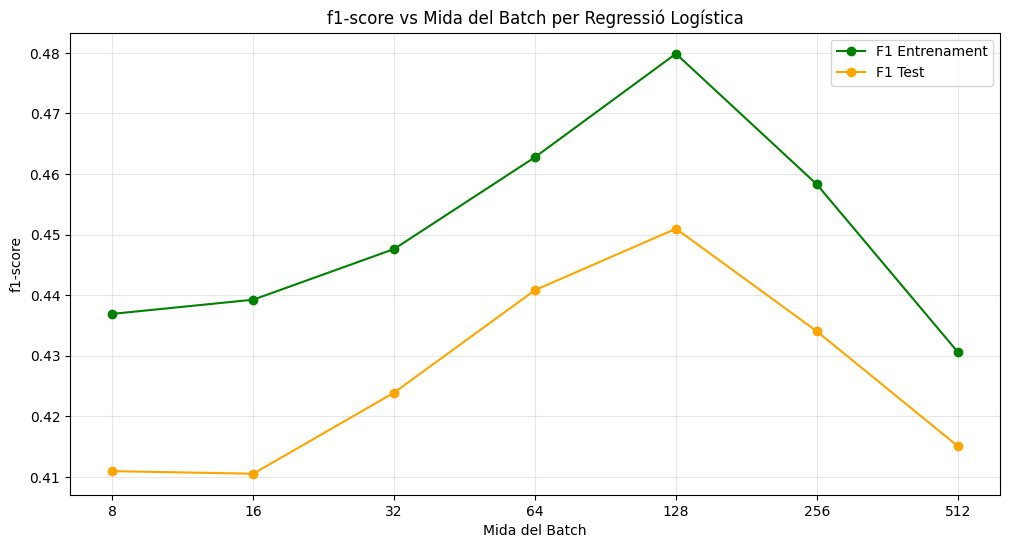

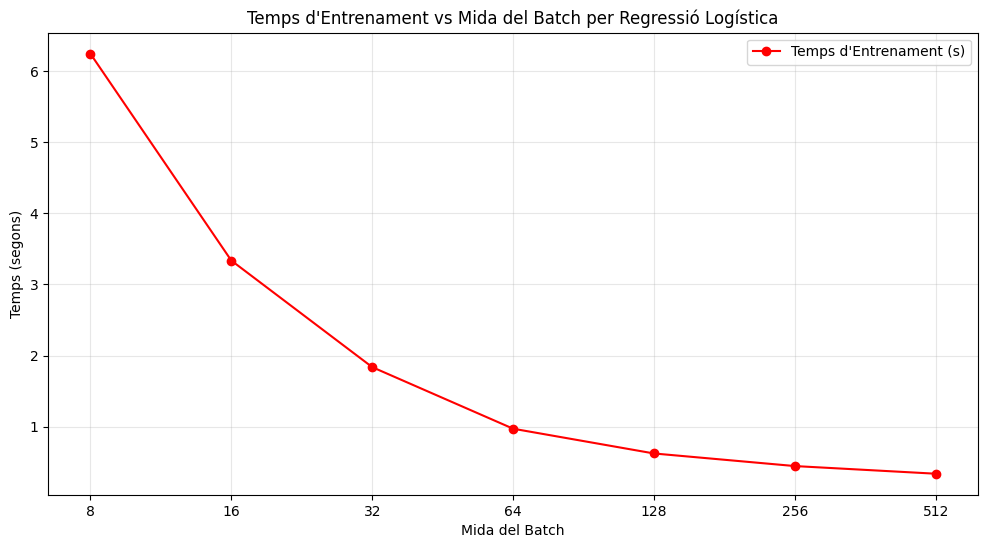

In [46]:
import time
#mirem batch de 8 a 512
batch_sizes = [8, 16, 32, 64, 128, 256, 512]
train_f1s = []
test_f1s = []
times_elapsed = []
for batch_size in batch_sizes:
    model_lr = CustomLogisticRegression(
        learning_rate=0.0001,
        n_iterations=300,
        batch_size=batch_size,
        regularization='l2',
        lambda_reg=1,
        class_weight={0: 1, 1: 2},
        random_state=42
    )
    
    start_time = time.time()
    model_lr.fit(X_train_lr_final, y_train_lr)
    end_time = time.time()
    
    # calculem f1-score
    y_train_pred = model_lr.predict(X_train_lr_final)
    y_test_pred = model_lr.predict(X_test_lr_final)
    train_f1 = f1_score(y_train_lr, y_train_pred)
    test_f1 = f1_score(y_test_lr, y_test_pred)
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)

    times_elapsed.append(end_time - start_time)
    
# graficar resultats
plt.figure(figsize=(12, 6))
plt.plot(batch_sizes, train_f1s, '-o', label='F1 Entrenament', color='green')
plt.plot(batch_sizes, test_f1s, '-o', label='F1 Test', color='orange')
plt.xlabel('Mida del Batch')
plt.ylabel('f1-score')
plt.title('f1-score vs Mida del Batch per Regressió Logística')
plt.xscale('log', base=2)
plt.xticks(batch_sizes, batch_sizes)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
# graficar temps d'entrenament
plt.figure(figsize=(12, 6))
plt.plot(batch_sizes, times_elapsed, '-o', label='Temps d\'Entrenament (s)', color='red')
plt.xlabel('Mida del Batch')
plt.ylabel('Temps (segons)')
plt.title('Temps d\'Entrenament vs Mida del Batch per Regressió Logística')
plt.xscale('log', base=2)
plt.xticks(batch_sizes, batch_sizes)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()



Millor model serà el de batch_size = 128

In [49]:
# ajustem el millor model trobat
best_lr = CustomLogisticRegression(
    learning_rate=0.0001,
    n_iterations=300,
    batch_size=128,
    regularization='l2',
    lambda_reg=1,
    class_weight={0: 1, 1: 2},
    random_state=42
)
best_lr.fit(X_train_lr_final, y_train_lr)
y_pred_best_lr = best_lr.predict(X_test_lr_final)
print(classification_report(y_test_lr, y_pred_best_lr))

              precision    recall  f1-score   support

           0       0.74      0.63      0.68      1232
           1       0.39      0.53      0.45       568

    accuracy                           0.60      1800
   macro avg       0.57      0.58      0.57      1800
weighted avg       0.63      0.60      0.61      1800



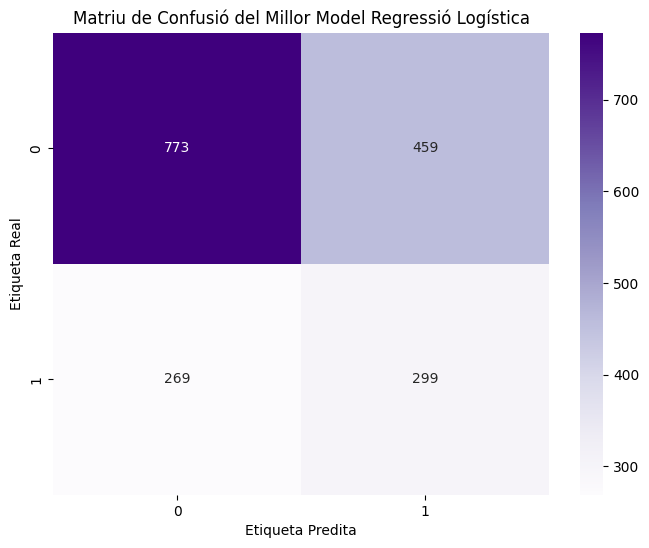

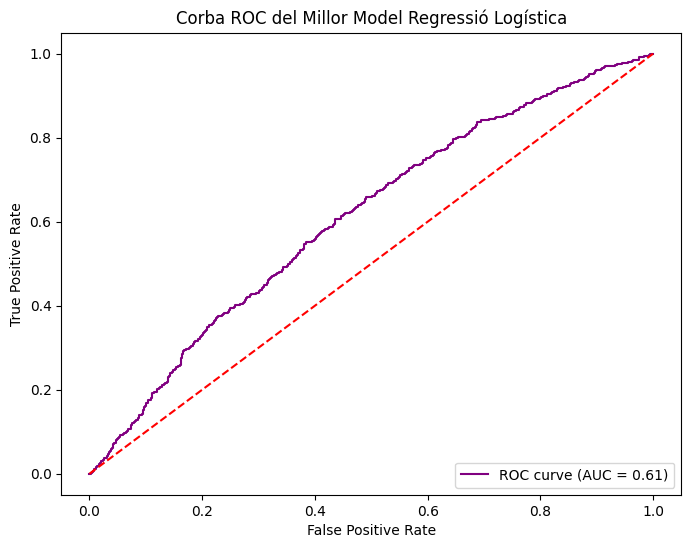

In [50]:
#matriu de confusió
cm_lr = confusion_matrix(y_test_lr, y_pred_best_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Purples', 
            xticklabels=best_lr.classes_, 
            yticklabels=best_lr.classes_)
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predita')
plt.title('Matriu de Confusió del Millor Model Regressió Logística')
plt.show()
# Corba ROC i AUC
y_prob_best_lr = best_lr.predict_proba(X_test_lr_final)[:, 1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test_lr, y_prob_best_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.figure(figsize=(8, 6))  
plt.plot(fpr_lr, tpr_lr, color='purple', label=f'ROC curve (AUC = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Corba ROC del Millor Model Regressió Logística')
plt.legend(loc='lower right')
plt.show()

Fem una submission amb el model entrenat

In [53]:
# fem tot el preprocessing per les dades d'avaluació
df_eval_lr = pd.read_csv('trs_eval.csv')
eval_ids_lr = df_eval_lr['patient_id']
X_eval_lr = df_eval_lr.drop('patient_id', axis=1) if 'patient_id' in df_eval_lr.columns else df_eval_lr.copy()
print(f"Dimensions inicials eval LR: {X_eval_lr.shape}")
# eliminem les mateixes columnes que abans
X_eval_lr = X_eval_lr.drop(columns=cols_to_remove, errors='ignore')
# One-Hot Encoding
cat_cols_eval_lr = X_eval_lr.select_dtypes(include=['object']).columns.tolist()
num_cols_eval_lr = X_eval_lr.select_dtypes(exclude=['object']).columns.tolist()
X_eval_cat_lr = ohe_lr.transform(X_eval_lr[cat_cols_eval_lr])
X_eval_cat_df_lr = pd.DataFrame(X_eval_cat_lr, columns=new_names, index=X_eval_lr.index)
X_eval_step2_lr = pd.concat([X_eval_lr[num_cols_eval_lr], X_eval_cat_df_lr], axis=1)
print(f"Dimensions després One-Hot LR: {X_eval_step2_lr.shape}")
# Imputació KNN
X_eval_scaled_temp_lr = scaler_temp_lr.transform(X_eval_step2_lr)
X_eval_imputed_lr = knn_lr.transform(X_eval_scaled_temp_lr)
X_eval_step3_lr = pd.DataFrame(scaler_temp_lr.inverse_transform(X_eval_imputed_lr), 
                            columns=X_eval_step2_lr.columns, index=X_eval_step2_lr.index)
print(f"NaNs restants LR: {X_eval_step3_lr.isnull().sum().sum()}")
# Transformació Yeo-Johnson
X_eval_step3_lr[cols_skewed] = pt_lr.transform(X_eval_step3_lr[cols_skewed])
print("Transformació Yeo-Johnson aplicada a les dades d'avaluació LR.")
# Escalat final
X_eval_final_lr = scaler_final_lr.transform(X_eval_step3_lr)
print("Escalat final aplicat a les dades d'avaluació LR.")
# Prediccions   
final_predictions_lr = best_lr.predict(X_eval_final_lr)
submission_lr = pd.DataFrame({
    'patient_id': eval_ids_lr,
    'TRS': final_predictions_lr
})
submission_lr.to_csv('submission_lr.csv', index=False)


Dimensions inicials eval LR: (1000, 26)
Dimensions després One-Hot LR: (1000, 25)
NaNs restants LR: 0
Transformació Yeo-Johnson aplicada a les dades d'avaluació LR.
Escalat final aplicat a les dades d'avaluació LR.
